---
# **Property Assessment CCAO** 
### **FIN 550 Final Project**

This R script contains the full workflow to:
   - Load and process (ETL) Cook County property datasets
   - Perform Exploratory Data Analysis (EDA)
   - Develop and apply models for predicting residential property values
 
The script produces the final 'assessed_value.csv' file for project submission.


---
### **Extract, Transform, Load**

##### Install & Load Required Packages

In [45]:
# Install and load required packages

# Function to install packages if not already installed
install_if_missing <- function(package) {
  if (!require(package, character.only = TRUE, quietly = TRUE)) {
    install.packages(package, dependencies = TRUE)
  }
}

# Data manipulation and ETL
install_if_missing("readr")
install_if_missing("dplyr")
install_if_missing("tidyr")
install_if_missing("data.table")
install_if_missing("e1071")

# EDA and visualization
install_if_missing("ggplot2")
install_if_missing("gridExtra")
install_if_missing("corrplot")
install_if_missing("GGally")
install_if_missing("skimr")

# Modeling - Linear Models
install_if_missing("caret")
install_if_missing("glmnet")

# Modeling - Tree-based methods
install_if_missing("rpart")
install_if_missing("rpart.plot")
install_if_missing("randomForest")
install_if_missing("ranger")
install_if_missing("rBayesianOptimization")
install_if_missing("xgboost")
install_if_missing("Matrix")

# Model evaluation and tuning
install_if_missing("Metrics")
install_if_missing("MLmetrics")

# Missing data imputation
install_if_missing("mice")

# Load libraries
library(readr)                 # Reading CSV files
library(dplyr)                 # Data manipulation
library(tidyr)                 # Data tidying
library(data.table)            # Fast data manipulation
library(e1071)                 # Skewness calculation

library(ggplot2)               # Visualization
library(gridExtra)             # Grid of plots
library(corrplot)              # Correlation plots
library(GGally)                # Pairwise plots
library(skimr)                 # Summary statistics

library(caret)                 # Model training and evaluation
library(glmnet)                # Regularized regression (Ridge, Lasso, Elastic Net)

library(rpart)                 # Decision trees
library(rpart.plot)            # Decision tree visualization
library(randomForest)          # Random Forest
library(ranger)                # Random Forest
library(rBayesianOptimization) # Optuna Titration & Convergence
library(xgboost)               # XGBoost
library(Matrix)                # Sparse Matrix Operations

library(Metrics)               # Model evaluation metrics
library(MLmetrics)             # Additional ML metrics

library(mice)                  # Multiple imputation by chained equations

# Set random seed for reproducibility
set.seed(550)

cat("All required packages loaded successfully.\n")


Attaching package: ‘e1071’


The following object is masked from ‘package:ggplot2’:

    element




All required packages loaded successfully.


##### Load the Datasets

In [46]:
# Load the datasets
historic_data <- read_csv('data/historic_property_data.csv')
predict_set <- read_csv('data/predict_property_data.csv')

# Display basic information about the datasets
cat("Historic Data Shape:", dim(historic_data), "\n")
cat("Predict Set Shape:", dim(predict_set), "\n")

Rows: 50000 Columns: 63
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): meta_cdu, meta_deed_type, geo_property_city, geo_property_zip, geo...
dbl (52): sale_price, meta_class, meta_town_code, meta_nbhd, meta_certified_...
lgl  (3): ind_large_home, ind_garage, ind_arms_length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10000 Columns: 63
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): meta_cdu, meta_deed_type, geo_property_city, geo_property_zip, geo...
dbl (52): pid, meta_class, meta_town_code, meta_nbhd, meta_certified_est_bld...
lgl  (3): ind_large_home, ind_garage, ind_arms_length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Historic Data Shape: 50000 63 
Predict Set Shape: 10000 63 


##### Data Types *(Nominal, Ordinal, Integer, Continuous, Booleen)*

##### Ordinal Reclass

These categorical fields have a meaningful order and are candidates for coercion to ordered factors

In [47]:
# =====================================================
# ORDINAL VARIABLES: MARK AS ORDERED + REPORT LEVELS
# =====================================================

cat("=== Ordinal Reclassification (mark ordered, no coercion) ===\n")

# Variables we want to treat as ordinal (names only)
ordinal_vars <- c(
  "char_apts",
  "char_attic_fnsh",
  "char_attic_type",
  "char_bsmt_fin",
  "char_cnst_qlty",
  "char_gar1_size",
  "char_repair_cnd",
  "char_site",
  "char_type_resd",
  "geo_fs_flood_risk_direction",
  "geo_fs_flood_factor",
  "time_sale_quarter_of_year",
  "time_sale_month_of_year"
)

make_ordered_and_report <- function(df, dataset_name, vars) {
  for (var in vars) {
    if (!var %in% names(df)) next
    
    x <- df[[var]]
    # Work with whatever encoding is already present (numeric or character)
    x_char <- as.character(x)
    lv <- sort(unique(x_char[!is.na(x_char)]))
    
    df[[var]] <- factor(x_char, levels = lv, ordered = TRUE)
    
    cat(sprintf(
      "- [%s] %s: %d levels -> %s\n",
      dataset_name, var, length(lv), paste(lv, collapse = ", ")
    ))
  }
  df
}

# Apply to both datasets
historic_data <- make_ordered_and_report(historic_data, "historic_data", ordinal_vars)
predict_set   <- make_ordered_and_report(predict_set,   "predict_set",   ordinal_vars)

# Optional: update codebook_df metadata
if (exists("codebook_df")) {
  idx <- which(codebook_df$var_name_standard %in% ordinal_vars)
  if (length(idx)) {
    codebook_df$var_type[idx]      <- "Ordinal"
    codebook_df$var_data_type[idx] <- "categorical"
  }
}

cat("Ordinal marking complete (no new levels created, none coerced to NA).\n")

=== Ordinal Reclassification (mark ordered, no coercion) ===
- [historic_data] char_apts: 6 levels -> 1, 2, 3, 4, 5, 6
- [historic_data] char_attic_fnsh: 3 levels -> 1, 2, 3
- [historic_data] char_attic_type: 3 levels -> 1, 2, 3
- [historic_data] char_bsmt_fin: 3 levels -> 1, 2, 3
- [historic_data] char_cnst_qlty: 2 levels -> 1, 2
- [historic_data] char_gar1_size: 8 levels -> 1, 2, 3, 4, 5, 6, 7, 8
- [historic_data] char_repair_cnd: 3 levels -> 1, 2, 3
- [historic_data] char_site: 3 levels -> 1, 2, 3
- [historic_data] char_type_resd: 9 levels -> 1, 2, 3, 4, 5, 6, 7, 8, 9
- [historic_data] geo_fs_flood_risk_direction: 3 levels -> -1, 0, 1
- [historic_data] geo_fs_flood_factor: 10 levels -> 1, 10, 2, 3, 4, 5, 6, 7, 8, 9
- [predict_set] char_apts: 6 levels -> 1, 2, 3, 4, 5, 6
- [predict_set] char_attic_fnsh: 3 levels -> 1, 2, 3
- [predict_set] char_attic_type: 3 levels -> 1, 2, 3
- [predict_set] char_bsmt_fin: 3 levels -> 1, 2, 3
- [predict_set] char_cnst_qlty: 2 levels -> 1, 2
- [predict

#### Numeric Reclassification (Integer vs Continuous)


In [48]:
# Reclassify numeric variables into Integer vs Continuous (codebook-informed, manual lists)
cat("=== Numeric Reclassification (Integer vs Continuous) ===\n")

# Updated classification, see reclassification prompt for rationale
integer_vars <- c(
  "char_age",                        # Age in years
  "char_beds",                       # Count of bedrooms
  "char_fbath",                      # Count of full baths
  "char_frpl",                       # Count of fireplaces
  "char_hbath",                      # Count of half baths
  "char_ncu",                        # Count of commercial units
  "char_rooms",                      # Count of rooms
  "econ_foreclosures_month_town",    # Count
  "econ_foreclosures_quarter_town",  # Count
  "geo_tract_pop",                   # Population count
  "meta_year",                       # Year
  "meta_num_288s_active",            # Count
  "meta_num_288s_ended",             # Count
  "time_sale_year",                  # Year
  "time_sale_quarter",               # Count of quarters since 1997
  "time_sale_month",                 # Count of months since 1997
  "time_sale_week",                  # Count of weeks since 1997
  "time_sale_day",                   # Count of days since 1997
  "time_sale_week_of_year",          # 1-52
  "time_sale_day_of_year"            # 1-365
)

continuous_vars <- c(
  "char_bldg_sf",                    # Square footage
  "char_hd_sf",                      # Land square footage
  "char_ot_impr",                    # Value of other improvements
  "char_volume",                     # Volume measurement
  "econ_midincome",                  # Median Income
  "econ_tax_amt_paid",               # Currency
  "econ_tax_rate",                   # Rate
  "geo_black_perc",                  # Percentage
  "geo_asian_perc",                  # Percentage
  "geo_his_perc",                    # Percentage
  "geo_white_perc",                  # Percentage
  "geo_other_perc",                  # Percentage
  "geo_longitude",                   # Coordinate
  "geo_latitude",                    # Coordinate
  "meta_per_ass",                    # Percentage
  "meta_2yr_pri_board_est_bldg",     # Currency
  "meta_2yr_pri_board_est_land",     # Currency
  "meta_1yr_pri_board_est_bldg",     # Currency
  "meta_1yr_pri_board_est_land",     # Currency
  "meta_mailed_est_bldg",            # Currency
  "meta_mailed_est_land",            # Currency
  "meta_certified_est_bldg",         # Currency
  "meta_certified_est_land",         # Currency
  "meta_sale_price",                 # Currency
  "meta_nbhd_avg",                   # Currency
  "meta_nbhd_med",                   # Currency
  "sale_price"                       # Currency
)

numeric_vars_all <- c(integer_vars, continuous_vars)

cat(sprintf("Identified %d integer vars, %d continuous vars\n", length(integer_vars), length(continuous_vars)))

=== Numeric Reclassification (Integer vs Continuous) ===
Identified 20 integer vars, 27 continuous vars


#### Boolean Reclassification

In [49]:
# ==============================================================================
# Reframing Binary Nominal Variables as Logical
# ==============================================================================

# The following variables have the codebook pattern: 1 = "Yes", 2 = "No".
# We convert them to TRUE/FALSE.

binary_yes_no_vars <- c(
  "char_air",         # 1=Central A/C, 2=No Central A/C
  "char_gar1_area",   # 1=Yes (Garage in bldg area), 2=No
  "char_gar1_att",    # 1=Yes (Attached), 2=No
  "char_renovation",  # 1=Yes, 2=No
  "char_tp_dsgn"      # 1=Yes (Cathedral Ceiling), 2=No
)

convert_to_logical <- function(df, vars) {
  # Filter for vars that actually exist in the dataframe
  vars_present <- vars[vars %in% names(df)]
  
  if(length(vars_present) > 0) {
    cat(sprintf("Converting %d variables to LOGICAL (1=TRUE, 2=FALSE)...\n", length(vars_present)))
    
    for (v in vars_present) {
      original_vals <- df[[v]]
      new_vals <- dplyr::case_when(
        original_vals %in% c(1, "1") ~ TRUE,
        original_vals %in% c(2, "2") ~ FALSE,
        TRUE ~ NA
      )
      df[[v]] <- new_vals
    }
  }
  return(df)
}

# Apply to datasets
historic_data <- convert_to_logical(historic_data, binary_yes_no_vars)
predict_set   <- convert_to_logical(predict_set, binary_yes_no_vars)

# List of all boolean/logical variables for classification code below
boolean_vars <- c(
  "geo_floodplain",
  "geo_ohare_noise",
  "geo_withinmr100",
  "geo_withinmr101300",
  "ind_multi_code",
  "ind_large_home",
  "ind_class_error",
  "ind_large_lot",
  "ind_garage",
  "ind_pure_market",
  "time_sale_during_school_year",
  "time_sale_during_holidays",
  binary_yes_no_vars
)

# Verification
cat("\nVerification of Logical Conversion:\n")
str(historic_data[binary_yes_no_vars[binary_yes_no_vars %in% names(historic_data)]])

Converting 5 variables to LOGICAL (1=TRUE, 2=FALSE)...
Converting 5 variables to LOGICAL (1=TRUE, 2=FALSE)...

Verification of Logical Conversion:
tibble [50,000 × 5] (S3: tbl_df/tbl/data.frame)
 $ char_air       : logi [1:50000] FALSE TRUE FALSE FALSE FALSE TRUE ...
 $ char_gar1_area : logi [1:50000] FALSE FALSE TRUE FALSE FALSE FALSE ...
 $ char_gar1_att  : logi [1:50000] FALSE TRUE TRUE FALSE FALSE TRUE ...
 $ char_renovation: logi [1:50000] NA NA NA NA NA NA ...
 $ char_tp_dsgn   : logi [1:50000] NA NA NA NA FALSE NA ...


In [50]:
# Helper function: maps each variable name to its type label (character value)
# Returns a named vector where names are variables in df, values are types ("Integer", "Continuous", "Boolean", "Ordinal", "Nominal")

get_var_type_map <- function(df) {
  # Detect if ordinal_vars exists
  ord_vars <- if (exists("ordinal_vars")) ordinal_vars else character()
  all_vars <- names(df)
  type_map <- setNames(rep("Nominal", length(all_vars)), all_vars)
  type_map[all_vars %in% integer_vars]    <- "Integer"
  type_map[all_vars %in% continuous_vars] <- "Continuous"
  type_map[all_vars %in% boolean_vars]    <- "Boolean"
  type_map[all_vars %in% ord_vars]        <- "Ordinal"
  return(type_map)
}

# Example: get type mapping for later use
var_type_map_historic <- get_var_type_map(historic_data)
var_type_map_predict  <- get_var_type_map(predict_set)

# Print simple summary of variable counts by type
cat("\n=== Variable Type Counts (from Classification Vectors) ===\n")

summarize_types <- function(df, dataset_name) {
  type_map <- get_var_type_map(df)
  n_integer    <- sum(type_map == "Integer")
  n_continuous <- sum(type_map == "Continuous")
  n_boolean    <- sum(type_map == "Boolean")
  n_ordinal    <- sum(type_map == "Ordinal")
  n_nominal    <- sum(type_map == "Nominal")
  cat(sprintf("%s:\n", dataset_name))
  cat(sprintf("  Integer     : %2d vars\n", n_integer))
  cat(sprintf("  Continuous  : %2d vars\n", n_continuous))
  cat(sprintf("  Boolean     : %2d vars\n", n_boolean))
  cat(sprintf("  Ordinal     : %2d vars\n", n_ordinal))
  cat(sprintf("  Nominal     : %2d vars\n", n_nominal))
}

summarize_types(historic_data, "Historic Data")
summarize_types(predict_set, "Predict Set")


=== Variable Type Counts (from Classification Vectors) ===
Historic Data:
  Integer     :  7 vars
  Continuous  : 13 vars
  Boolean     : 11 vars
  Ordinal     : 11 vars
  Nominal     : 21 vars
Predict Set:
  Integer     :  7 vars
  Continuous  : 12 vars
  Boolean     : 11 vars
  Ordinal     : 11 vars
  Nominal     : 22 vars


---
### **NA Handling & MICE**

##### Observe Missing Values

In [51]:
# Analyze percent of all *data* (cells) missing by type
cat("=== Percent of Total Data Missing by Variable Type ===\n")

# Function to calculate % of total *data cells* missing per type
analyze_missing_by_dtype <- function(data, dataset_name) {
  cat(paste0(dataset_name, ":\n"))
  all_vars <- names(data)
  n_rows <- nrow(data)
  # Get type for all columns
  dtype_per_col <- get_var_type_map(data)[all_vars]
  types_for_summary <- c("Integer", "Continuous", "Nominal", "Ordinal", "Boolean")
  # How many cells ("slots") exist of each type
  slots_by_type <- sapply(types_for_summary, function(t) sum(dtype_per_col == t) * n_rows)
  # How many missing cells by type
  missing_by_type <- sapply(types_for_summary, function(t) {
    these_cols <- all_vars[dtype_per_col == t]
    if(length(these_cols) == 0) return(0)
    sum(is.na(data[these_cols]))
  })
  total_cells <- n_rows * ncol(data)
  total_missing <- sum(is.na(data))
  pct_missing_by_type <- ifelse(slots_by_type > 0, missing_by_type / total_cells * 100, 0)
  names(missing_by_type) <- types_for_summary
  names(pct_missing_by_type) <- types_for_summary
  for (type_str in types_for_summary) {
    cat(sprintf("  %-11s: %.2f%% of total data cells missing (%d/%d cells)\n", 
                type_str,
                round(pct_missing_by_type[type_str], 2),
                missing_by_type[type_str],
                total_cells))
  }
  cat(sprintf("  Total:       %.2f%% of total data cells missing (%d/%d cells)\n", 
              round(total_missing/total_cells*100, 2), 
              total_missing, 
              total_cells))
}

analyze_missing_by_dtype(historic_data, "Historic Data")
analyze_missing_by_dtype(predict_set, "Predict Set")

=== Percent of Total Data Missing by Variable Type ===
Historic Data:
  Integer    : 0.01% of total data cells missing (187/3150000 cells)
  Continuous : 0.03% of total data cells missing (972/3150000 cells)
  Nominal    : 3.57% of total data cells missing (112470/3150000 cells)
  Ordinal    : 2.45% of total data cells missing (77077/3150000 cells)
  Boolean    : 2.91% of total data cells missing (91787/3150000 cells)
  Total:       8.97% of total data cells missing (282493/3150000 cells)
Predict Set:
  Integer    : 0.00% of total data cells missing (3/630000 cells)
  Continuous : 0.00% of total data cells missing (0/630000 cells)
  Nominal    : 3.52% of total data cells missing (22179/630000 cells)
  Ordinal    : 2.47% of total data cells missing (15568/630000 cells)
  Boolean    : 2.83% of total data cells missing (17835/630000 cells)
  Total:       8.82% of total data cells missing (55585/630000 cells)


In [52]:
# Print all columns and their missing % for both datasets, ordered by Percent_Missing DESC
get_missing_pct_df <- function(df, dataset_name) { data.frame(Dataset = dataset_name, Column = names(df), Percent_Missing = round(colMeans(is.na(df)) * 100, 2), row.names = NULL) }

missing_historic <- get_missing_pct_df(historic_data, "historic_data")
missing_predict <- get_missing_pct_df(predict_set, "predict_set")

missing_all <- rbind(missing_historic, missing_predict)

# Order by Percent_Missing DESC
missing_all <- missing_all[order(-missing_all$Percent_Missing), ]

cat("\nAll columns and their percent missing (both datasets):\n")
print(missing_all)


All columns and their percent missing (both datasets):
          Dataset                      Column Percent_Missing
102   predict_set             char_renovation           99.51
39  historic_data             char_renovation           99.48
7   historic_data                    meta_cdu           94.34
70    predict_set                    meta_cdu           94.18
74    predict_set                   char_apts           87.78
11  historic_data                   char_apts           86.19
103   predict_set                  char_porch           82.45
40  historic_data                  char_porch           81.45
101   predict_set             char_attic_fnsh           67.62
38  historic_data             char_attic_fnsh           66.91
26  historic_data                char_tp_dsgn           54.35
89    predict_set                char_tp_dsgn           51.12
25  historic_data                char_tp_plan           28.79
88    predict_set                char_tp_plan           26.57
30  historic_d

##### Missing Value Handling *(Drop High-Missing Columns)*

- Drop any column with >50% missing values from both datasets

In [53]:
# Compute percent missing per column for both datasets
missing_historic_pct <- colMeans(is.na(historic_data)) * 100
missing_predict_pct <- colMeans(is.na(predict_set)) * 100

# Identify columns with >50% missing in historic data
high_missing_historic <- names(missing_historic_pct[missing_historic_pct > 50])
cat("\nColumns with >50% missing in historic data:", length(high_missing_historic), "\n")
if(length(high_missing_historic) > 0) print(high_missing_historic)

# Identify columns with >50% missing in predict set
high_missing_predict <- names(missing_predict_pct[missing_predict_pct > 50])
cat("\nColumns with >50% missing in predict set:", length(high_missing_predict), "\n")
if(length(high_missing_predict) > 0) print(high_missing_predict)

# Get union of columns to drop (present in either dataset)
cols_to_drop <- unique(c(high_missing_historic, high_missing_predict))
cat("\nTotal unique columns to drop:", length(cols_to_drop), "\n")

# Drop high-missing columns from both datasets
if(length(cols_to_drop) > 0) {
  cols_to_drop_historic <- intersect(cols_to_drop, names(historic_data))
  cols_to_drop_predict <- intersect(cols_to_drop, names(predict_set))
  if(length(cols_to_drop_historic) > 0) {
    historic_data <- historic_data %>% select(-all_of(cols_to_drop_historic))
    cat("Dropped", length(cols_to_drop_historic), "columns from historic data\n")
  }
  if(length(cols_to_drop_predict) > 0) {
    predict_set <- predict_set %>% select(-all_of(cols_to_drop_predict))
    cat("Dropped", length(cols_to_drop_predict), "columns from predict set\n")
  }
}

# Check remaining missing values
remaining_missing_historic <- sum(is.na(historic_data))
remaining_missing_predict <- sum(is.na(predict_set))
cat("\nRemaining missing values in historic data:", remaining_missing_historic, "\n")
cat("Remaining missing values in predict set:", remaining_missing_predict, "\n")


Columns with >50% missing in historic data: 6 
[1] "meta_cdu"        "char_apts"       "char_tp_dsgn"    "char_attic_fnsh"
[5] "char_renovation" "char_porch"     

Columns with >50% missing in predict set: 6 
[1] "meta_cdu"        "char_apts"       "char_tp_dsgn"    "char_attic_fnsh"
[5] "char_renovation" "char_porch"     

Total unique columns to drop: 6 
Dropped 6 columns from historic data
Dropped 6 columns from predict set

Remaining missing values in historic data: 41136 
Remaining missing values in predict set: 7319 


In [54]:
# Count remaining columns by type for each dataset

count_vars_by_type <- function(data, dataset_name) {
  dtype_map <- get_var_type_map(data)
  type_counts <- table(factor(dtype_map, levels = c("Integer", "Continuous", "Nominal", "Ordinal", "Boolean")))
  cat(paste0("=== Remaining Columns by Type in ", dataset_name, " ===\n"))
  for(type in names(type_counts)) {
    cat(sprintf("  %-11s: %d\n", type, type_counts[[type]]))
  }
  cat(sprintf("  Total:       %d columns\n\n", ncol(data)))
}

count_vars_by_type(historic_data, "Historic Data")
count_vars_by_type(predict_set, "Predict Set")

=== Remaining Columns by Type in Historic Data ===
  Integer    : 7
  Continuous : 13
  Nominal    : 19
  Ordinal    : 9
  Boolean    : 9
  Total:       57 columns

=== Remaining Columns by Type in Predict Set ===
  Integer    : 7
  Continuous : 12
  Nominal    : 20
  Ordinal    : 9
  Boolean    : 9
  Total:       57 columns



In [55]:
# Analyze percent missing by variable type (out of slots of that type)
cat("=== Percent Missing by Variable Type (out of each type's entries) ===\n")

# Function to calculate % missing per *type* (out of all values of just that type)
analyze_missing_by_dtype <- function(data, dataset_name) {
  cat(paste0(dataset_name, ":\n"))
  all_vars <- names(data)
  n_rows <- nrow(data)
  # Get type for all columns
  dtype_per_col <- get_var_type_map(data)[all_vars]
  types_for_summary <- c("Integer", "Continuous", "Nominal", "Ordinal", "Boolean")
  # How many cells ("slots") exist of each type
  slots_by_type <- sapply(types_for_summary, function(t) sum(dtype_per_col == t) * n_rows)
  # How many missing cells by type
  missing_by_type <- sapply(types_for_summary, function(t) {
    these_cols <- all_vars[dtype_per_col == t]
    if(length(these_cols) == 0) return(0)
    sum(is.na(data[these_cols]))
  })
  total_cells <- n_rows * ncol(data)
  total_missing <- sum(is.na(data))
  pct_missing_by_type <- ifelse(slots_by_type > 0, missing_by_type / slots_by_type * 100, 0)
  names(missing_by_type) <- types_for_summary
  names(pct_missing_by_type) <- types_for_summary
  for (type_str in types_for_summary) {
    cat(sprintf("  %-11s: %.2f%% missing in this type (%d/%d cells)\n", 
                type_str,
                round(pct_missing_by_type[type_str], 2),
                missing_by_type[type_str],
                slots_by_type[type_str]))
  }
  cat(sprintf("  Total:       %.2f%% of total data cells missing (%d/%d cells)\n", 
              round(total_missing/total_cells*100, 2), 
              total_missing, 
              total_cells))
}

analyze_missing_by_dtype(historic_data, "Historic Data")
analyze_missing_by_dtype(predict_set, "Predict Set")

=== Percent Missing by Variable Type (out of each type's entries) ===
Historic Data:
  Integer    : 0.05% missing in this type (187/350000 cells)
  Continuous : 0.15% missing in this type (972/650000 cells)
  Nominal    : 2.59% missing in this type (24573/950000 cells)
  Ordinal    : 0.12% missing in this type (531/450000 cells)
  Boolean    : 3.31% missing in this type (14873/450000 cells)
  Total:       1.44% of total data cells missing (41136/2850000 cells)
Predict Set:
  Integer    : 0.00% missing in this type (3/70000 cells)
  Continuous : 0.00% missing in this type (0/120000 cells)
  Nominal    : 2.26% missing in this type (4516/200000 cells)
  Ordinal    : 0.03% missing in this type (28/90000 cells)
  Boolean    : 3.08% missing in this type (2772/90000 cells)
  Total:       1.28% of total data cells missing (7319/570000 cells)


##### Missing Value Handling *(MICE Protocol)*

- **MICE Imputation** — Apply multivariate imputation by chained equations to remaining missing values:

   - ***PMM*** *(Predictive Mean Matching)* *{Numeric variables}*: Predicts missing values by matching to observed values with similar predicted means, preserving the original distribution
   - ***CART*** *(Classification and Regression Trees)* *{Categorical Variables}*: Uses decision tree models to predict missing categories based on other variables
   - ***LogReg*** *(Logistic Regression)* *{Logical/Binary Variables}*: Models the probability of TRUE/FALSE outcomes using logistic regression

 - MICE preserves relationships between variables and maintains distributional properties

In [56]:
# =====================================================
# PRE-IMPUTATION: CONVERT CATEGORICALS & BOOLEANS TO FACTORS (SAFE)
# =====================================================

cat("\n=== Converting Nominal/Ordinal vars to factor, Boolean vars to TRUE/FALSE factor only ===\n")
flush.console()

cb_type_lookup_hist <- get_var_type_map(historic_data)
cb_type_lookup_pred <- get_var_type_map(predict_set)

coerce_bool_column <- function(x, col_name, dataset_name) {
  cls <- class(x)[1]

  # Logical → factor(FALSE, TRUE)
  if (is.logical(x)) {
    x_fac <- factor(x, levels = c(FALSE, TRUE))
    cat(sprintf("  [%s] %s: logical → factor(FALSE/TRUE)\n", dataset_name, col_name))
    return(x_fac)
  }

  # Numeric/integer {0,1} → factor(FALSE, TRUE)
  if (is.numeric(x) || is.integer(x)) {
    u <- sort(unique(na.omit(x)))
    if (length(u) <= 2 && all(u %in% c(0, 1))) {
      x_logic <- ifelse(is.na(x), NA, as.logical(x))
      x_fac <- factor(x_logic, levels = c(FALSE, TRUE))
      cat(sprintf("  [%s] %s: numeric {0,1} → logical → factor(FALSE/TRUE)\n", dataset_name, col_name))
      return(x_fac)
    } else {
      warning(sprintf("[%s] %s labeled Boolean but numeric with values: %s; treating as nominal factor.",
                      dataset_name, col_name, paste(u, collapse = ", ")))
      return(factor(x))
    }
  }

  # Factor with 2 levels 
  if (is.factor(x)) {
    # Case 1: 2 levels and are exactly c("FALSE", "TRUE") or logical labels
    lv <- levels(x)
    if (length(lv) == 2) {
      # Accept also if they're 0/1 and can be mapped to logical
      if (all(lv %in% c("FALSE", "TRUE"))) {
        cat(sprintf("  [%s] %s: factor(FALSE,TRUE) kept as Boolean factor\n",
                    dataset_name, col_name))
        return(factor(x, levels = c("FALSE", "TRUE")))
      } else if (all(lv %in% c("0","1"))) {
        # Convert to logical, then factor(FALSE,TRUE)
        x_logic <- ifelse(is.na(x), NA, as.logical(as.integer(as.character(x))))
        x_fac <- factor(x_logic, levels = c(FALSE, TRUE))
        cat(sprintf("  [%s] %s: factor(0,1) → logical → factor(FALSE/TRUE)\n", dataset_name, col_name))
        return(x_fac)
      } else {
        # Otherwise, treat as logical only if value labels can be interpreted as logical
        # Try coercion and warn otherwise
        x_logic <- suppressWarnings(as.logical(as.character(x)))
        if (all(is.na(x_logic) == is.na(x))) {
          # only if all levels are interpretable as logical
          cat(sprintf("  [%s] %s: factor(2-level, coerced to logical) → factor(FALSE/TRUE)\n", dataset_name, col_name))
          return(factor(x_logic, levels = c(FALSE, TRUE)))
        } else {
          warning(sprintf("[%s] %s labeled Boolean but factor with other levels (%s); leaving as factor.",
                          dataset_name, col_name, paste(lv, collapse = ", ")))
          return(x)
        }
      }
    } else {
      warning(sprintf("[%s] %s labeled Boolean but factor with %d levels; leaving as factor.",
                      dataset_name, col_name, length(lv)))
      return(x)
    }
  }

  # Fallback
  warning(sprintf("[%s] %s labeled Boolean but type %s; coercing to factor.",
                  dataset_name, col_name, cls))
  factor(x)
}

# Historic data
for (col in names(historic_data)) {
  if (!col %in% names(cb_type_lookup_hist)) next
  col_type <- cb_type_lookup_hist[[col]]

  # Nominal/Ordinal → factor
  if (col_type %in% c("Nominal", "Ordinal") && !is.factor(historic_data[[col]])) {
    historic_data[[col]] <- factor(historic_data[[col]])
    cat(sprintf("  [historic_data] %s: %s → factor (%d levels)\n",
                col, col_type, nlevels(historic_data[[col]])))
  }

  # Boolean → TRUE/FALSE factor only
  if (col_type == "Boolean") {
    historic_data[[col]] <- coerce_bool_column(historic_data[[col]], col, "historic_data")
  }
}

# Predict set
for (col in names(predict_set)) {
  if (!col %in% names(cb_type_lookup_pred)) next
  col_type <- cb_type_lookup_pred[[col]]

  if (col_type %in% c("Nominal", "Ordinal") && !is.factor(predict_set[[col]])) {
    predict_set[[col]] <- factor(predict_set[[col]])
    cat(sprintf("  [predict_set] %s: %s → factor (%d levels)\n",
                col, col_type, nlevels(predict_set[[col]])))
  }

  if (col_type == "Boolean") {
    predict_set[[col]] <- coerce_bool_column(predict_set[[col]], col, "predict_set")
  }
}

cat("Categorical/Boolean factor conversion complete.\n")
cat(sprintf("Timestamp: %s\n", Sys.time()))
flush.console()


=== Converting Nominal/Ordinal vars to factor, Boolean vars to TRUE/FALSE factor only ===
  [historic_data] meta_class: Nominal → factor (14 levels)
  [historic_data] meta_town_code: Nominal → factor (38 levels)
  [historic_data] meta_nbhd: Nominal → factor (845 levels)
  [historic_data] meta_deed_type: Nominal → factor (3 levels)
  [historic_data] char_ext_wall: Nominal → factor (4 levels)
  [historic_data] char_roof_cnst: Nominal → factor (6 levels)
  [historic_data] char_bsmt: Nominal → factor (4 levels)
  [historic_data] char_heat: Nominal → factor (4 levels)
  [historic_data] char_oheat: Nominal → factor (2 levels)
  [historic_data] char_air: logical → factor(FALSE/TRUE)
  [historic_data] char_tp_plan: Nominal → factor (2 levels)
  [historic_data] char_gar1_cnst: Nominal → factor (4 levels)
  [historic_data] char_gar1_att: logical → factor(FALSE/TRUE)
  [historic_data] char_gar1_area: logical → factor(FALSE/TRUE)
  [historic_data] char_use: Nominal → factor (2 levels)
  [historic

In [57]:
# =====================================================
# BASELINE SNAPSHOTS (Pre-MICE)
# =====================================================
cat("\n[BASELINE] Creating pre-MICE snapshots...\n"); flush.console()

# Create baseline snapshots before any MICE imputation
historic_snapshot_pre_mice <- historic_data
predict_snapshot_pre_mice  <- predict_set

cat("  Baseline snapshots created:\n")
cat(sprintf("    historic_snapshot_pre_mice: %d rows, %d cols\n", nrow(historic_snapshot_pre_mice), ncol(historic_snapshot_pre_mice)))
cat(sprintf("    predict_snapshot_pre_mice:  %d rows, %d cols\n", nrow(predict_snapshot_pre_mice), ncol(predict_snapshot_pre_mice)))
cat(sprintf("Timestamp: %s\n", Sys.time()))
flush.console()


[BASELINE] Creating pre-MICE snapshots...
  Baseline snapshots created:
    historic_snapshot_pre_mice: 50000 rows, 57 cols
    predict_snapshot_pre_mice:  10000 rows, 57 cols
Timestamp: 2025-12-02 17:56:59.579301


In [58]:
# ==========================================
# SUMMARY: COUNT VARS + NAs BY TYPE/DATASET
# ==========================================

summarize_types_and_nas <- function(df, dataset_name) {
  # Always recompute type map from the CURRENT df
  type_map <- get_var_type_map(df)
  
  type_categories <- c("Integer", "Continuous", "Nominal", "Ordinal", "Boolean", "Other")
  
  # Count columns by type
  type_vec <- unlist(type_map)
  type_vec[!(type_vec %in% type_categories)] <- "Other"
  type_counts <- table(factor(type_vec, levels = type_categories))
  
  # Count NAs by type (only over existing columns)
  na_count <- setNames(integer(length(type_categories)), type_categories)
  for (col in names(df)) {
    col_type <- type_map[[col]]
    if (is.null(col_type) || !(col_type %in% type_categories)) {
      col_type <- "Other"
    }
    na_count[col_type] <- na_count[col_type] + sum(is.na(df[[col]]))
  }
  
  cat(sprintf("=== %s: Columns by Type ===\n", dataset_name))
  for (tp in type_categories) {
    cat(sprintf("  %-10s: %d\n", tp, type_counts[tp]))
  }
  cat(sprintf("  Total columns: %d\n\n", ncol(df)))
  
  cat(sprintf("[NA COUNT] %s:\n", dataset_name))
  for (tp in type_categories) {
    cat(sprintf("  %-10s: %d\n", tp, na_count[tp]))
  }
  cat("\n")
  
  invisible(list(type_map = type_map, na_count = na_count))
}

# Call for both datasets
hist_summary  <- summarize_types_and_nas(historic_data, "historic_data")
pred_summary  <- summarize_types_and_nas(predict_set,   "predict_set")

# Keep the type maps around explicitly
var_type_map_historic <- hist_summary$type_map
var_type_map_predict  <- pred_summary$type_map

cat(sprintf("Timestamp: %s\n", Sys.time())); flush.console()

=== historic_data: Columns by Type ===
  Integer   : 7
  Continuous: 13
  Nominal   : 19
  Ordinal   : 9
  Boolean   : 9
  Other     : 0
  Total columns: 57

[NA COUNT] historic_data:
  Integer   : 187
  Continuous: 972
  Nominal   : 24573
  Ordinal   : 531
  Boolean   : 14873
  Other     : 0

=== predict_set: Columns by Type ===
  Integer   : 7
  Continuous: 12
  Nominal   : 20
  Ordinal   : 9
  Boolean   : 9
  Other     : 0
  Total columns: 57

[NA COUNT] predict_set:
  Integer   : 3
  Continuous: 0
  Nominal   : 4516
  Ordinal   : 28
  Boolean   : 2772
  Other     : 0

Timestamp: 2025-12-02 17:56:59.59402


In [59]:
# =====================================================
# BLOCK 1: NUMERIC IMPUTATION (PMM ONLY)
# =====================================================
cat("\n[NUMERIC BLOCK] Starting numeric-only MICE run...\n")
flush.console()
set.seed(2047)

# Helper: Robustly identify numeric columns based on codebook or data type
get_numeric_cols <- function(df, cb_types) {
  # 1. Try codebook lookup
  vars <- names(df)[sapply(names(df), function(col) {
    type <- tryCatch(codebook_col_type(col, cb_types), error = function(e) NA)
    type %in% c("Integer", "Continuous")
  })]
  
  # 2. Fallback: If codebook returns empty (or error), use is.numeric
  if (length(vars) == 0) {
    vars <- names(df)[sapply(df, is.numeric)]
  }
  return(vars)
}

# Helper: Identify columns that are safe to use as predictors
# (Excludes IDs, Addresses, and High-Cardinality Factors)
get_safe_predictors <- function(df) {
  names(df)[sapply(df, function(x) {
    # Must be numeric OR (factor/char with < 50 unique levels)
    is.numeric(x) || (length(unique(x)) < 50)
  })]
}

numeric_cols_hist <- get_numeric_cols(historic_data, cb_types)
numeric_cols_pred <- get_numeric_cols(predict_set, cb_types)

# Find columns with missing values
numeric_missing_hist <- numeric_cols_hist[colSums(is.na(historic_data[numeric_cols_hist])) > 0]
numeric_missing_pred <- numeric_cols_pred[colSums(is.na(predict_set[numeric_cols_pred])) > 0]

cat(sprintf("  Found %d numeric variables in historic_data\n", length(numeric_cols_hist)))
cat(sprintf("  Found %d numeric variables in predict_set\n", length(numeric_cols_pred)))
cat(sprintf("  %d numeric vars with NAs in historic_data\n", length(numeric_missing_hist)))
cat(sprintf("  %d numeric vars with NAs in predict_set\n", length(numeric_missing_pred)))
flush.console()

impute_numeric <- function(df, dataset_name, numeric_cols) {
  # 1. Identify Target Columns
  target_cols <- numeric_cols[colSums(is.na(df[numeric_cols])) > 0]
  
  if (!length(target_cols)) { 
    cat(sprintf("  [%s] No numeric NAs detected, skipping.\n", dataset_name))
    return(df) 
  }
  
  cat(sprintf("  [%s] Imputing %d numeric vars via PMM...\n", dataset_name, length(target_cols)))
  
  # 2. Setup Methods Vector (Only impute target columns)
  methods <- rep("", ncol(df))
  names(methods) <- names(df)
  methods[target_cols] <- "pmm"
  
  # 3. Optimize Predictor Matrix (CRITICAL FIX FOR HANGING)
  # We identify columns that should NOT be used as predictors (High cardinality strings/IDs)
  safe_predictors <- get_safe_predictors(df)
  unsafe_predictors <- setdiff(names(df), safe_predictors)
  
  cat(sprintf("  [%s] Excluding %d high-cardinality/ID cols from predictors to prevent hanging.\n", 
              dataset_name, length(unsafe_predictors)))
  flush.console()
  
  # Use quickpred, but explicitly exclude unsafe columns
  start_time <- Sys.time()
  pred_matrix <- quickpred(df, 
                           mincor = 0.4, 
                           minpuc = 0.5,
                           exclude = unsafe_predictors) # <--- Prevents using IDs/Addresses
  
  # 4. Run MICE
  # We suppress the "logged events" warning slightly by increasing max variable checks if needed, 
  # but quickpred exclusion usually solves it.
  mice_obj <- mice(df,
                   m = 3,
                   method = methods,
                   predictorMatrix = pred_matrix,
                   ridge = 1e-5,
                   maxit = 2,
                   seed = 550,
                   printFlag = FALSE) # Set to FALSE to reduce console spam, we measure time manually
  
  elapsed <- difftime(Sys.time(), start_time, units = "mins")
  cat(sprintf("  [%s] Numeric MICE finished in %.2f minutes\n", dataset_name, elapsed))
  flush.console()
  
  # 5. Return Completed Data
  complete(mice_obj, 1)
}

historic_data <- impute_numeric(historic_data, "Historic", numeric_cols_hist)
predict_set   <- impute_numeric(predict_set,   "Predict", numeric_cols_pred)

cat("[NUMERIC BLOCK] Completed. Remaining numeric NAs:", 
    sum(is.na(historic_data[numeric_cols_hist])), "(historic),", 
    sum(is.na(predict_set[numeric_cols_pred])), "(predict)\n")


[NUMERIC BLOCK] Starting numeric-only MICE run...
  Found 20 numeric variables in historic_data
  Found 19 numeric variables in predict_set
  8 numeric vars with NAs in historic_data
  1 numeric vars with NAs in predict_set
  [Historic] Imputing 8 numeric vars via PMM...
  [Historic] Excluding 7 high-cardinality/ID cols from predictors to prevent hanging.
  [Historic] Numeric MICE finished in 0.03 minutes
  [Predict] Imputing 1 numeric vars via PMM...
  [Predict] Excluding 8 high-cardinality/ID cols from predictors to prevent hanging.
  [Predict] Numeric MICE finished in 0.00 minutes
[NUMERIC BLOCK] Completed. Remaining numeric NAs: 0 (historic), 0 (predict)


In [60]:
# =====================================================
# BLOCK 2: BOOLEAN IMPUTATION (LOGREG + STRICT FALLBACK)
# =====================================================
cat("\n[BOOLEAN BLOCK] Starting boolean-only imputation with logreg + strict fallback...\n")
set.seed(2047)

# Rebuild type maps AFTER conversion and dropping
var_type_map_historic <- get_var_type_map(historic_data)
var_type_map_predict  <- get_var_type_map(predict_set)

# Mode imputer that also handles 100% NA columns
simple_boolean_mode_impute <- function(x, col_name, dataset_name) {
  ux <- na.omit(x)

  # 100% NA: choose conservative default
  if (length(ux) == 0) {
    if (is.factor(x)) {
      lv <- levels(x)
      if (length(lv) == 0L) {
        warning(sprintf("[%s] %s: all NA and factor has no levels; leaving as all NA.",
                        dataset_name, col_name))
        return(x)
      }
      # Prefer FALSE/0 if present, otherwise first level
      if (any(lv %in% c("FALSE", "0"))) {
        m_name <- lv[lv %in% c("FALSE", "0")][1L]
      } else {
        m_name <- lv[1L]
      }
      x[] <- m_name
      cat(sprintf("    [%s] %s: all NA → filled with factor level '%s'\n",
                  dataset_name, col_name, m_name))
      return(x)
    } else if (is.logical(x)) {
      x[] <- FALSE
      cat(sprintf("    [%s] %s: all NA logical → filled with FALSE\n",
                  dataset_name, col_name))
      return(x)
    } else if (is.numeric(x) || is.integer(x)) {
      x[] <- 0L
      cat(sprintf("    [%s] %s: all NA numeric → filled with 0\n",
                  dataset_name, col_name))
      return(x)
    } else {
      warning(sprintf("[%s] %s: all NA, unsupported type %s; leaving as NA.",
                      dataset_name, col_name, class(x)[1]))
      return(x)
    }
  }

  # Regular mode case
  tb <- table(ux)
  m_name <- names(tb)[which.max(tb)]

  if (is.factor(x)) {
    m <- factor(m_name, levels = levels(x))
  } else if (is.logical(x)) {
    m <- as.logical(m_name)
  } else if (is.numeric(x) || is.integer(x)) {
    m <- as.numeric(m_name)
  } else {
    m <- ux[1]
  }

  x[is.na(x)] <- m
  x
}

get_unsafe_predictors <- function(df) {
  names(df)[sapply(df, function(x) {
    (is.character(x) || is.factor(x)) &&
      (length(unique(na.omit(x))) > 50)
  })]
}

coerce_bool_targets_for_mice <- function(df, target_cols, dataset_name) {
  meta <- lapply(target_cols, function(col) {
    x <- df[[col]]
    list(
      col    = col,
      class  = class(x)[1],
      levels = if (is.factor(x)) levels(x) else NULL
    )
  })
  names(meta) <- target_cols

  out <- df
  for (col in target_cols) {
    x <- out[[col]]
    if (is.logical(x)) {
      out[[col]] <- factor(x, levels = c(FALSE, TRUE))
    } else if (is.factor(x) && nlevels(x) == 2) {
      out[[col]] <- droplevels(x)
    } else if ((is.numeric(x) || is.integer(x)) &&
               all(na.omit(x) %in% c(0, 1))) {
      out[[col]] <- factor(x, levels = c(0, 1))
    } else {
      warning(sprintf("[%s] %s labeled Boolean but unsuitable for logreg; leaving as-is for MICE.",
                      dataset_name, col))
    }
  }

  list(df = out, meta = meta)
}

cast_back_bool_targets <- function(df, meta) {
  out <- df
  for (col in names(meta)) {
    if (!col %in% names(out)) next
    m <- meta[[col]]
    x <- out[[col]]

    if (m$class == "logical") {
      out[[col]] <- as.logical(as.character(x))
    } else if (m$class %in% c("integer", "numeric")) {
      out[[col]] <- as.integer(as.character(x))
    } else if (m$class == "factor") {
      if (!is.null(m$levels)) {
        out[[col]] <- factor(as.character(x), levels = m$levels)
      } else {
        out[[col]] <- factor(x)
      }
    }
  }
  out
}

impute_boolean_with_logreg <- function(df, dataset_name, type_map) {
  bool_cols <- names(type_map)[type_map == "Boolean"]
  bool_cols <- intersect(bool_cols, names(df))

  if (length(bool_cols) == 0) {
    cat(sprintf("  [%s] No Boolean columns detected, skipping.\n", dataset_name))
    return(df)
  }

  target_cols <- bool_cols[colSums(is.na(df[, bool_cols, drop = FALSE])) > 0]
  if (length(target_cols) == 0) {
    cat(sprintf("  [%s] Boolean columns have no NAs, skipping.\n", dataset_name))
    return(df)
  }

  cat(sprintf("  [%s] Imputing %d Boolean vars via 'logreg' with fallback...\n",
              dataset_name, length(target_cols)))

  unsafe_cols <- get_unsafe_predictors(df)
  cat(sprintf("  [%s] Excluding %d high-cardinality predictors.\n",
              dataset_name, length(unsafe_cols)))
  flush.console()

  prep    <- coerce_bool_targets_for_mice(df, target_cols, dataset_name)
  df_mice <- prep$df
  meta    <- prep$meta

  methods <- rep("", ncol(df_mice))
  names(methods) <- names(df_mice)
  methods[target_cols] <- "logreg"

  mice_failed_or_incomplete <- FALSE
  cols_remaining_na <- character(0)
  result <- df_mice

  tryCatch({
    start_time <- Sys.time()

    pred_matrix <- quickpred(
      df_mice,
      mincor = 0.3,
      minpuc = 0.4,
      exclude = unsafe_cols
    )

    mice_obj <- mice(
      df_mice,
      m = 3,
      method = methods,
      predictorMatrix = pred_matrix,
      ridge = 1e-5,
      maxit = 2,
      seed = 551,
      printFlag = FALSE
    )

    elapsed <- difftime(Sys.time(), start_time, units = "mins")
    cat(sprintf("  [%s] Boolean MICE finished in %.2f minutes\n",
                dataset_name, elapsed))
    flush.console()

    result <- complete(mice_obj, 1)
    result <- result[, names(df_mice), drop = FALSE]

    cols_remaining_na <- target_cols[
      colSums(is.na(result[, target_cols, drop = FALSE])) > 0
    ]
    if (length(cols_remaining_na) > 0) {
      mice_failed_or_incomplete <- TRUE
      warning(sprintf("[%s] MICE did not impute all: %s. Fallback to mode imputation.",
                      dataset_name, paste(cols_remaining_na, collapse = ", ")))
    }
  }, error = function(e) {
    mice_failed_or_incomplete <<- TRUE
    warning(sprintf("[%s] MICE error: %s. Fallback to mode imputation for all Boolean targets.",
                    dataset_name, e$message))
    cols_remaining_na <<- target_cols
  })

  # Strict fallback: fill everything, even 100% NA columns
  if (length(cols_remaining_na) > 0) {
    for (col in cols_remaining_na) {
      old_na <- sum(is.na(result[[col]]))
      result[[col]] <- simple_boolean_mode_impute(result[[col]], col, dataset_name)
      new_na <- sum(is.na(result[[col]]))
      cat(sprintf("    [%s] Fallback imputed %s: %d -> %d NAs\n",
                  dataset_name, col, old_na, new_na))
    }
  }

  result <- cast_back_bool_targets(result, meta)

  bool_cols_final <- intersect(names(type_map)[type_map == "Boolean"], names(result))
  rem_na <- sum(is.na(result[, bool_cols_final, drop = FALSE]))
  cat(sprintf("  [%s] Remaining Boolean NAs (across all Boolean cols): %d\n",
              dataset_name, rem_na))

  result
}

historic_data <- impute_boolean_with_logreg(historic_data, "historic_data", var_type_map_historic)
predict_set   <- impute_boolean_with_logreg(predict_set,   "predict_set",   var_type_map_predict)

# Rebuild type maps if you need them for later steps
var_type_map_historic <- get_var_type_map(historic_data)
var_type_map_predict  <- get_var_type_map(predict_set)

bool_hist <- names(var_type_map_historic)[var_type_map_historic == "Boolean"]
bool_pred <- names(var_type_map_predict)[var_type_map_predict  == "Boolean"]

cat(sprintf("[BOOLEAN BLOCK] Completed. Remaining Boolean NAs: %d (historic), %d (predict)\n",
            sum(is.na(historic_data[, bool_hist, drop = FALSE])),
            sum(is.na(predict_set[,   bool_pred, drop = FALSE]))))
flush.console()


[BOOLEAN BLOCK] Starting boolean-only imputation with logreg + strict fallback...
  [historic_data] Imputing 8 Boolean vars via 'logreg' with fallback...
  [historic_data] Excluding 7 high-cardinality predictors.


Warning message:
“Number of logged events: 12”


  [historic_data] Boolean MICE finished in 0.26 minutes


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“[historic_data] MICE did not impute all: char_gar1_att, char_gar1_area. Fallback to mode imputation.”


    [historic_data] Fallback imputed char_gar1_att: 24 -> 0 NAs
    [historic_data] Fallback imputed char_gar1_area: 24 -> 0 NAs
  [historic_data] Remaining Boolean NAs (across all Boolean cols): 0
  [predict_set] Imputing 4 Boolean vars via 'logreg' with fallback...
  [predict_set] Excluding 8 high-cardinality predictors.


Warning message:
“Number of logged events: 12”


  [predict_set] Boolean MICE finished in 0.03 minutes


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“[predict_set] MICE did not impute all: char_gar1_att, char_gar1_area. Fallback to mode imputation.”


    [predict_set] Fallback imputed char_gar1_att: 3 -> 0 NAs
    [predict_set] Fallback imputed char_gar1_area: 3 -> 0 NAs
  [predict_set] Remaining Boolean NAs (across all Boolean cols): 0
[BOOLEAN BLOCK] Completed. Remaining Boolean NAs: 0 (historic), 0 (predict)


In [61]:
# =====================================================
# BLOCK 3.1: CHARACTER IMPUTATION - DIRECT SAMPLING ONLY (HARDCODED NOMINAL CHARACTER VARS)
# =====================================================
cat("\n[CHARACTER BLOCK] Starting nominal character variable imputation (HARDCODED LIST)...\n")
cat("Strategy: Direct sampling (these character variables are high-cardinality IDs/codes)\n")
flush.console()
set.seed(2047)

# Direct sampling imputation function
impute_sample_direct <- function(x) { 
  if(sum(is.na(x)) == 0) return(x)
  obs_vals <- x[!is.na(x)]
  if(length(obs_vals) == 0) return(x)
  x[is.na(x)] <- sample(obs_vals, sum(is.na(x)), replace=TRUE)
  return(x)
}

# Nominal Character Variables (HARDCODED for direct sampling imputation)
nominal_char_vars <- c(
  # Economic
  "econ_tax_cd",
  
  # Geographic IDs and Names
  "geo_census_tract",
  "geo_geoid",
  "geo_commissioner_dist",
  "geo_fips",
  "geo_municipality",
  "geo_school_elem_district",
  "geo_school_hs_district",
  "geo_puma",
  "geo_reps_dist",
  "geo_senate_dist",
  "geo_tif_agencynum",
  "geo_ward",
  "geo_ssa_name",
  "geo_ssa_no",
  
  # Geographic Addresses
  "geo_property_address",
  "geo_property_apt_no",
  "geo_property_city",
  "geo_property_zip",
  "geo_mailing_address",
  "geo_mailing_state",
  "geo_mailing_city",
  "geo_mailing_zip",
  
  # Metadata IDs, Codes, and Types
  "meta_cdu",
  "meta_class",
  "meta_document_num",
  "meta_key_pin",
  "meta_multi_code",
  "meta_modeling_group",
  "meta_nbhd",
  "meta_pin",
  "meta_town_name",
  "meta_town_code",
  "meta_deed_type"
)

# Only keep those that actually exist in the dataset
character_cols_hist <- nominal_char_vars[nominal_char_vars %in% names(historic_data)]
character_cols_pred <- nominal_char_vars[nominal_char_vars %in% names(predict_set)]

# Find columns with missing values
character_missing_hist <- character_cols_hist[colSums(is.na(historic_data[character_cols_hist])) > 0]
character_missing_pred <- character_cols_pred[colSums(is.na(predict_set[character_cols_pred])) > 0]

cat(sprintf("Nominal character columns with missing (historic): %d\n", length(character_missing_hist)))
cat(sprintf("Nominal character columns with missing (predict): %d\n\n", length(character_missing_pred)))
flush.console()

# ============ HISTORIC DATA ============
if(length(character_missing_hist) > 0) {
  cat("[CHARACTER] Processing historic data (hardcoded nominal character columns)...\n")
  for(i in seq_along(character_missing_hist)) {
    col <- character_missing_hist[i]
    n_missing <- sum(is.na(historic_data[[col]]))
    n_unique <- length(unique(historic_data[[col]][!is.na(historic_data[[col]])]))
    
    cat(sprintf("[%d/%d] %s: %d missing, %d unique values -> ", 
                i, length(character_missing_hist), col, n_missing, n_unique))
    flush.console()
    
    historic_data[[col]] <- impute_sample_direct(historic_data[[col]])
    cat("COMPLETE\n")
    flush.console()
  }
  cat("\n[CHARACTER] Historic data imputation COMPLETE (nominal character vars)\n")
  cat(sprintf("  Remaining NAs: %d\n\n", sum(is.na(historic_data))))
  flush.console()
}

# ============ PREDICT SET ============
if(length(character_missing_pred) > 0) {
  cat("[CHARACTER] Processing predict set (hardcoded nominal character columns)...\n")
  for(i in seq_along(character_missing_pred)) {
    col <- character_missing_pred[i]
    n_missing <- sum(is.na(predict_set[[col]]))
    n_unique <- length(unique(predict_set[[col]][!is.na(predict_set[[col]])]))
    
    cat(sprintf("[%d/%d] %s: %d missing, %d unique values -> ", 
                i, length(character_missing_pred), col, n_missing, n_unique))
    flush.console()
    
    predict_set[[col]] <- impute_sample_direct(predict_set[[col]])
    cat("COMPLETE\n")
    flush.console()
  }
  cat("\n[CHARACTER] Predict set imputation COMPLETE (nominal character vars)\n")
  cat(sprintf("  Remaining NAs: %d\n\n", sum(is.na(predict_set))))
  flush.console()
}

cat("[BLOCK 3.2 CHARACTER] COMPLETED\n")
cat("Final missing values:\n")
cat("  Historic:", sum(is.na(historic_data)), "\n")
cat("  Predict:", sum(is.na(predict_set)), "\n\n")
flush.console()


[CHARACTER BLOCK] Starting nominal character variable imputation (HARDCODED LIST)...
Strategy: Direct sampling (these character variables are high-cardinality IDs/codes)
Nominal character columns with missing (historic): 6
Nominal character columns with missing (predict): 4

[CHARACTER] Processing historic data (hardcoded nominal character columns)...
[1/6] geo_fips: 1103 missing, 126 unique values -> COMPLETE
[2/6] geo_municipality: 1103 missing, 126 unique values -> COMPLETE
[3/6] geo_school_elem_district: 162 missing, 475 unique values -> COMPLETE
[4/6] geo_school_hs_district: 162 missing, 79 unique values -> COMPLETE
[5/6] geo_property_city: 131 missing, 132 unique values -> COMPLETE
[6/6] geo_property_zip: 131 missing, 169 unique values -> COMPLETE

[CHARACTER] Historic data imputation COMPLETE (nominal character vars)
  Remaining NAs: 22312

[CHARACTER] Processing predict set (hardcoded nominal character columns)...
[1/4] geo_fips: 213 missing, 125 unique values -> COMPLETE
[2/4

In [62]:
# =====================================================
# BLOCK 3.2: NOMINAL IMPUTATION - ONE AT A TIME
# =====================================================
cat("\n[NOMINAL BLOCK] Starting sequential nominal imputation...\n")
cat("Strategy: MICE 'sample' for ≤10 categories, Direct sampling for >10 categories\n")
flush.console(); set.seed(2047)

# Helper function for direct sampling
impute_sample_direct <- function(x) { 
  if(sum(is.na(x)) == 0) return(x)
  obs_vals <- x[!is.na(x)]; if(length(obs_vals) == 0) return(x)
  x[is.na(x)] <- sample(obs_vals, sum(is.na(x)), replace=TRUE)
  return(x)
}

# Use updated helper to get type mapping and identify nominal columns correctly
var_type_map_hist <- get_var_type_map(historic_data)
var_type_map_pred <- get_var_type_map(predict_set)

# Exclude columns hardcoded as character vars in previous cell
nominal_cols_hist <- setdiff(names(var_type_map_hist)[var_type_map_hist == "Nominal"], character_missing_hist)
nominal_cols_pred <- setdiff(names(var_type_map_pred)[var_type_map_pred == "Nominal"], character_missing_pred)

# Find columns with missing values and sort by missingness (ASCENDING)
nominal_missing_hist <- nominal_cols_hist[colSums(is.na(historic_data[nominal_cols_hist])) > 0]
nominal_missing_pred <- nominal_cols_pred[colSums(is.na(predict_set[nominal_cols_pred])) > 0]

# Order by missingness (least to greatest)
if(length(nominal_missing_hist) > 0) {
  miss_counts_hist <- colSums(is.na(historic_data[nominal_missing_hist]))
  nominal_missing_hist <- names(sort(miss_counts_hist))
}
if(length(nominal_missing_pred) > 0) {
  miss_counts_pred <- colSums(is.na(predict_set[nominal_missing_pred]))
  nominal_missing_pred <- names(sort(miss_counts_pred))
}

cat(sprintf("Nominal columns with missing (historic): %d\n", length(nominal_missing_hist)))
cat(sprintf("Nominal columns with missing (predict): %d\n\n", length(nominal_missing_pred)))
flush.console()

# ============ HISTORIC DATA ============
if(length(nominal_missing_hist) > 0) {
  cat("[NOMINAL] Processing historic data...\n"); flush.console()
  for(i in seq_along(nominal_missing_hist)) {
    col <- nominal_missing_hist[i]
    n_missing_before <- sum(is.na(historic_data[[col]]))
    n_levels <- length(levels(historic_data[[col]]))
    cat(sprintf("[%d/%d] %s: %d missing, %d levels -> ", i, length(nominal_missing_hist), col, n_missing_before, n_levels))
    flush.console()
    if(n_levels <= 10) {
      cat("using MICE 'sample'... ")
      flush.console()
      tryCatch({
        methods <- rep("", ncol(historic_data)); names(methods) <- names(historic_data); methods[col] <- "sample"
        pred_matrix <- quickpred(historic_data, mincor = 0.3, minpuc = 0.5)
        mice_obj <- mice(historic_data, m = 1, method = methods, predictorMatrix = pred_matrix, maxit = 1, seed = 552 + i, printFlag = FALSE)
        historic_data <- complete(mice_obj, 1)
        n_missing_after <- sum(is.na(historic_data[[col]]))
        # If MICE didn't fully impute, use direct sampling as fallback
        if(n_missing_after > 0) {
          cat("MICE incomplete, applying direct sampling... "); flush.console()
          historic_data[[col]] <- impute_sample_direct(historic_data[[col]])
          n_missing_after <- sum(is.na(historic_data[[col]]))
        }
        cat(sprintf("COMPLETE (imputed %d values, %d remaining)\n", n_missing_before - n_missing_after, n_missing_after)); flush.console()
      }, error = function(e) {
        cat("MICE failed, using direct sampling... "); flush.console()
        historic_data[[col]] <<- impute_sample_direct(historic_data[[col]])
        n_missing_after <- sum(is.na(historic_data[[col]]))
        cat(sprintf("COMPLETE (imputed %d values, %d remaining)\n", n_missing_before - n_missing_after, n_missing_after)); flush.console()
      })
    } else {
      # Direct sampling for high-cardinality
      cat("using direct sampling... "); flush.console()
      historic_data[[col]] <- impute_sample_direct(historic_data[[col]])
      n_missing_after <- sum(is.na(historic_data[[col]]))
      cat(sprintf("COMPLETE (imputed %d values, %d remaining)\n", n_missing_before - n_missing_after, n_missing_after)); flush.console()
    }
  }
  # Final pass: ensure all nominal columns are fully imputed
  remaining_nominal_na <- nominal_cols_hist[colSums(is.na(historic_data[nominal_cols_hist])) > 0]
  if(length(remaining_nominal_na) > 0) {
    cat("\n[NOMINAL] Final pass: imputing remaining NAs via direct sampling...\n")
    for(col in remaining_nominal_na) {
      n_before <- sum(is.na(historic_data[[col]]))
      historic_data[[col]] <- impute_sample_direct(historic_data[[col]])
      n_after <- sum(is.na(historic_data[[col]]))
      cat(sprintf("  %s: imputed %d values\n", col, n_before - n_after))
    }
  }
  cat("\n[NOMINAL] Historic data imputation COMPLETE\n"); 
  cat(sprintf("  Remaining nominal NAs: %d\n", sum(is.na(historic_data[nominal_cols_hist]))))
  cat(sprintf("  Total remaining NAs: %d\n\n", sum(is.na(historic_data))))
  flush.console()
}

# ============ PREDICT SET ============
if(length(nominal_missing_pred) > 0) {
  cat("[NOMINAL] Processing predict set...\n"); flush.console()
  for(i in seq_along(nominal_missing_pred)) {
    col <- nominal_missing_pred[i]
    n_missing_before <- sum(is.na(predict_set[[col]]))
    n_levels <- length(levels(predict_set[[col]]))
    cat(sprintf("[%d/%d] %s: %d missing, %d levels -> ", i, length(nominal_missing_pred), col, n_missing_before, n_levels)); flush.console()
    if(n_levels <= 10) {
      cat("using MICE 'sample'... "); flush.console()
      tryCatch({
        methods <- rep("", ncol(predict_set)); names(methods) <- names(predict_set); methods[col] <- "sample"
        pred_matrix <- quickpred(predict_set, mincor = 0.3, minpuc = 0.5)
        mice_obj <- mice(predict_set, m = 1, method = methods, predictorMatrix = pred_matrix, maxit = 1, seed = 552 + i, printFlag = FALSE)
        predict_set <- complete(mice_obj, 1)
        n_missing_after <- sum(is.na(predict_set[[col]]))
        # If MICE didn't fully impute, use direct sampling as fallback
        if(n_missing_after > 0) {
          cat("MICE incomplete, applying direct sampling... "); flush.console()
          predict_set[[col]] <- impute_sample_direct(predict_set[[col]])
          n_missing_after <- sum(is.na(predict_set[[col]]))
        }
        cat(sprintf("COMPLETE (imputed %d values, %d remaining)\n", n_missing_before - n_missing_after, n_missing_after)); flush.console()
      }, error = function(e) {
        cat("MICE failed, using direct sampling... "); flush.console()
        predict_set[[col]] <<- impute_sample_direct(predict_set[[col]])
        n_missing_after <- sum(is.na(predict_set[[col]]))
        cat(sprintf("COMPLETE (imputed %d values, %d remaining)\n", n_missing_before - n_missing_after, n_missing_after)); flush.console()
      })
    } else {
      # Direct sampling for high-cardinality
      cat("using direct sampling... "); flush.console()
      predict_set[[col]] <- impute_sample_direct(predict_set[[col]])
      n_missing_after <- sum(is.na(predict_set[[col]]))
      cat(sprintf("COMPLETE (imputed %d values, %d remaining)\n", n_missing_before - n_missing_after, n_missing_after)); flush.console()
    }
  }
  # Final pass: ensure all nominal columns are fully imputed
  remaining_nominal_na <- nominal_cols_pred[colSums(is.na(predict_set[nominal_cols_pred])) > 0]
  if(length(remaining_nominal_na) > 0) {
    cat("\n[NOMINAL] Final pass: imputing remaining NAs via direct sampling...\n")
    for(col in remaining_nominal_na) {
      n_before <- sum(is.na(predict_set[[col]]))
      predict_set[[col]] <- impute_sample_direct(predict_set[[col]])
      n_after <- sum(is.na(predict_set[[col]]))
      cat(sprintf("  %s: imputed %d values\n", col, n_before - n_after))
    }
  }
  cat("\n[NOMINAL] Predict set imputation COMPLETE\n"); 
  cat(sprintf("  Remaining nominal NAs: %d\n", sum(is.na(predict_set[nominal_cols_pred]))))
  cat(sprintf("  Total remaining NAs: %d\n\n", sum(is.na(predict_set))))
  flush.console()
}

cat("[BLOCK 3.1 NOMINAL] COMPLETED\n")
cat("Final missing values:\n"); 
cat("  Historic:", sum(is.na(historic_data)), "\n"); 
cat("  Predict:", sum(is.na(predict_set)), "\n\n"); 
flush.console()


[NOMINAL BLOCK] Starting sequential nominal imputation...
Strategy: MICE 'sample' for ≤10 categories, Direct sampling for >10 categories


Nominal columns with missing (historic): 8
Nominal columns with missing (predict): 8

[NOMINAL] Processing historic data...
[1/8] char_use: 24 missing, 2 levels -> using MICE 'sample'... COMPLETE (imputed 24 values, 0 remaining)
[2/8] char_bsmt: 25 missing, 4 levels -> using MICE 'sample'... COMPLETE (imputed 25 values, 0 remaining)
[3/8] char_ext_wall: 26 missing, 4 levels -> using MICE 'sample'... COMPLETE (imputed 26 values, 0 remaining)
[4/8] char_roof_cnst: 26 missing, 6 levels -> using MICE 'sample'... COMPLETE (imputed 26 values, 0 remaining)
[5/8] char_heat: 26 missing, 4 levels -> using MICE 'sample'... COMPLETE (imputed 26 values, 0 remaining)
[6/8] char_oheat: 172 missing, 2 levels -> using MICE 'sample'... COMPLETE (imputed 172 values, 0 remaining)
[7/8] char_gar1_cnst: 7088 missing, 4 levels -> using MICE 'sample'... 

Warning message:
“Number of logged events: 1”


MICE incomplete, applying direct sampling... COMPLETE (imputed 7088 values, 0 remaining)
[8/8] char_tp_plan: 14394 missing, 2 levels -> using MICE 'sample'... COMPLETE (imputed 14394 values, 0 remaining)

[NOMINAL] Historic data imputation COMPLETE
  Remaining nominal NAs: 0
  Total remaining NAs: 531

[NOMINAL] Processing predict set...
[1/8] char_ext_wall: 3 missing, 4 levels -> using MICE 'sample'... COMPLETE (imputed 3 values, 0 remaining)
[2/8] char_roof_cnst: 3 missing, 6 levels -> using MICE 'sample'... COMPLETE (imputed 3 values, 0 remaining)
[3/8] char_bsmt: 3 missing, 4 levels -> using MICE 'sample'... COMPLETE (imputed 3 values, 0 remaining)
[4/8] char_heat: 3 missing, 4 levels -> using MICE 'sample'... COMPLETE (imputed 3 values, 0 remaining)
[5/8] char_use: 3 missing, 2 levels -> using MICE 'sample'... COMPLETE (imputed 3 values, 0 remaining)
[6/8] char_oheat: 5 missing, 2 levels -> using MICE 'sample'... COMPLETE (imputed 5 values, 0 remaining)
[7/8] char_gar1_cnst: 1383 

Warning message:
“Number of logged events: 1”


MICE incomplete, applying direct sampling... COMPLETE (imputed 1383 values, 0 remaining)
[8/8] char_tp_plan: 2657 missing, 2 levels -> using MICE 'sample'... COMPLETE (imputed 2657 values, 0 remaining)

[NOMINAL] Predict set imputation COMPLETE
  Remaining nominal NAs: 0
  Total remaining NAs: 28

[BLOCK 3.1 NOMINAL] COMPLETED
Final missing values:
  Historic: 531 
  Predict: 28 



In [63]:
# =====================================================
# BLOCK 3.3: ORDINAL IMPUTATION - ONE AT A TIME
# =====================================================
cat("\n[ORDINAL BLOCK] Starting sequential ordinal imputation...\n")
cat("Strategy: MICE 'sample' for ≤10 categories, Direct sampling for >10 categories\n")
flush.console()
set.seed(2047)

# Use the updated codebook dtypes helper function to get variable type mapping
# (Assuming get_var_type_map is the updated helper and cb_types is available)
var_type_map_historic <- get_var_type_map(historic_data)
var_type_map_predict  <- get_var_type_map(predict_set)

# Identify ordinal columns by the updated variable type mapping
ordinal_cols_hist <- names(var_type_map_historic)[var_type_map_historic == "Ordinal"]
ordinal_cols_pred <- names(var_type_map_predict)[var_type_map_predict == "Ordinal"]

# Find columns with missing values and sort by missingness (ASCENDING)
ordinal_missing_hist <- ordinal_cols_hist[colSums(is.na(historic_data[ordinal_cols_hist])) > 0]
ordinal_missing_pred <- ordinal_cols_pred[colSums(is.na(predict_set[ordinal_cols_pred])) > 0]

# Order by missingness (least to greatest)
if(length(ordinal_missing_hist) > 0) {
  miss_counts_hist <- colSums(is.na(historic_data[ordinal_missing_hist]))
  ordinal_missing_hist <- names(sort(miss_counts_hist))
}

if(length(ordinal_missing_pred) > 0) {
  miss_counts_pred <- colSums(is.na(predict_set[ordinal_missing_pred]))
  ordinal_missing_pred <- names(sort(miss_counts_pred))
}

cat(sprintf("Ordinal columns with missing (historic): %d\n", length(ordinal_missing_hist)))
cat(sprintf("Ordinal columns with missing (predict): %d\n\n", length(ordinal_missing_pred)))
flush.console()

# ============ HISTORIC DATA ============
if(length(ordinal_missing_hist) > 0) {
  cat("[ORDINAL] Processing historic data...\n")
  flush.console()
  
  for(i in seq_along(ordinal_missing_hist)) {
    col <- ordinal_missing_hist[i]
    n_missing <- sum(is.na(historic_data[[col]]))
    n_levels <- if(is.factor(historic_data[[col]])) length(levels(historic_data[[col]])) else length(unique(na.omit(historic_data[[col]])))
    
    cat(sprintf("[%d/%d] %s: %d missing, %d levels -> ", 
                i, length(ordinal_missing_hist), col, n_missing, n_levels))
    flush.console()
    
    if(n_levels <= 10) {
      cat("using MICE 'sample'... ")
      flush.console()
      
      tryCatch({
        methods <- rep("", ncol(historic_data))
        names(methods) <- names(historic_data)
        methods[col] <- "sample"
        
        pred_matrix <- quickpred(historic_data, mincor = 0.3, minpuc = 0.5)
        
        mice_obj <- mice(historic_data,
                        m = 1,
                        method = methods,
                        predictorMatrix = pred_matrix,
                        maxit = 1,
                        seed = 554 + i,
                        printFlag = FALSE)
        
        historic_data <- complete(mice_obj, 1)
        cat("COMPLETE\n")
        flush.console()
      }, error = function(e) {
        cat("MICE failed, using direct sampling... ")
        flush.console()
        historic_data[[col]] <<- impute_sample_direct(historic_data[[col]])
        cat("COMPLETE\n")
        flush.console()
      })
    } else {
      cat("using direct sampling... ")
      flush.console()
      historic_data[[col]] <- impute_sample_direct(historic_data[[col]])
      cat("COMPLETE\n")
      flush.console()
    }
  }
  
  cat("\n[ORDINAL] Historic data imputation COMPLETE\n")
  cat(sprintf("  Remaining NAs: %d\n\n", sum(is.na(historic_data))))
  flush.console()
}

# ============ PREDICT SET ============
if(length(ordinal_missing_pred) > 0) {
  cat("[ORDINAL] Processing predict set...\n")
  flush.console()
  
  for(i in seq_along(ordinal_missing_pred)) {
    col <- ordinal_missing_pred[i]
    n_missing <- sum(is.na(predict_set[[col]]))
    n_levels <- if(is.factor(predict_set[[col]])) length(levels(predict_set[[col]])) else length(unique(na.omit(predict_set[[col]])))
    
    cat(sprintf("[%d/%d] %s: %d missing, %d levels -> ", 
                i, length(ordinal_missing_pred), col, n_missing, n_levels))
    flush.console()
    
    if(n_levels <= 10) {
      cat("using MICE 'sample'... ")
      flush.console()
      
      tryCatch({
        methods <- rep("", ncol(predict_set))
        names(methods) <- names(predict_set)
        methods[col] <- "sample"
        
        pred_matrix <- quickpred(predict_set, mincor = 0.3, minpuc = 0.5)
        
        mice_obj <- mice(predict_set,
                        m = 1,
                        method = methods,
                        predictorMatrix = pred_matrix,
                        maxit = 1,
                        seed = 554 + i,
                        printFlag = FALSE)
        
        predict_set <- complete(mice_obj, 1)
        cat("COMPLETE\n")
        flush.console()
      }, error = function(e) {
        cat("MICE failed, using direct sampling... ")
        flush.console()
        predict_set[[col]] <<- impute_sample_direct(predict_set[[col]])
        cat("COMPLETE\n")
        flush.console()
      })
    } else {
      cat("using direct sampling... ")
      flush.console()
      predict_set[[col]] <- impute_sample_direct(predict_set[[col]])
      cat("COMPLETE\n")
      flush.console()
    }
  }
  
  cat("\n[ORDINAL] Predict set imputation COMPLETE\n")
  cat(sprintf("  Remaining NAs: %d\n\n", sum(is.na(predict_set))))
  flush.console()
}

cat("[BLOCK 3.3 ORDINAL] COMPLETED\n")
cat("Final missing values:\n")
cat("  Historic:", sum(is.na(historic_data)), "\n")
cat("  Predict:", sum(is.na(predict_set)), "\n\n")
flush.console()


[ORDINAL BLOCK] Starting sequential ordinal imputation...
Strategy: MICE 'sample' for ≤10 categories, Direct sampling for >10 categories
Ordinal columns with missing (historic): 9
Ordinal columns with missing (predict): 7

[ORDINAL] Processing historic data...
[1/9] char_type_resd: 23 missing, 9 levels -> using MICE 'sample'... COMPLETE
[2/9] char_gar1_size: 24 missing, 8 levels -> using MICE 'sample'... COMPLETE
[3/9] char_bsmt_fin: 25 missing, 3 levels -> using MICE 'sample'... COMPLETE
[4/9] char_attic_type: 26 missing, 3 levels -> using MICE 'sample'... COMPLETE
[5/9] char_site: 26 missing, 3 levels -> using MICE 'sample'... COMPLETE
[6/9] char_repair_cnd: 26 missing, 3 levels -> using MICE 'sample'... COMPLETE
[7/9] char_cnst_qlty: 57 missing, 2 levels -> using MICE 'sample'... COMPLETE
[8/9] geo_fs_flood_factor: 162 missing, 10 levels -> using MICE 'sample'... COMPLETE
[9/9] geo_fs_flood_risk_direction: 162 missing, 3 levels -> using MICE 'sample'... COMPLETE

[ORDINAL] Historic

#### Summary: COUNT VARS + NAs BY TYPE/DATASET

In [64]:
summarize_types_and_nas <- function(df, dataset_name) {
  # Always recompute type map from the CURRENT df
  type_map <- get_var_type_map(df)
  
  type_categories <- c("Integer", "Continuous", "Nominal", "Ordinal", "Boolean", "Other")
  
  # Count columns by type
  type_vec <- unlist(type_map)
  type_vec[!(type_vec %in% type_categories)] <- "Other"
  type_counts <- table(factor(type_vec, levels = type_categories))
  
  # Count NAs by type (only over existing columns)
  na_count <- setNames(integer(length(type_categories)), type_categories)
  for (col in names(df)) {
    col_type <- type_map[[col]]
    if (is.null(col_type) || !(col_type %in% type_categories)) {
      col_type <- "Other"
    }
    na_count[col_type] <- na_count[col_type] + sum(is.na(df[[col]]))
  }
  
  cat(sprintf("=== %s: Columns by Type ===\n", dataset_name))
  for (tp in type_categories) {
    cat(sprintf("  %-10s: %d\n", tp, type_counts[tp]))
  }
  cat(sprintf("  Total columns: %d\n\n", ncol(df)))
  
  cat(sprintf("[NA COUNT] %s:\n", dataset_name))
  for (tp in type_categories) {
    cat(sprintf("  %-10s: %d\n", tp, na_count[tp]))
  }
  cat("\n")
  
  invisible(list(type_map = type_map, na_count = na_count))
}

# Call for both datasets
hist_summary  <- summarize_types_and_nas(historic_data, "historic_data")
pred_summary  <- summarize_types_and_nas(predict_set,   "predict_set")

# Keep the type maps around explicitly
var_type_map_historic <- hist_summary$type_map
var_type_map_predict  <- pred_summary$type_map

cat(sprintf("Timestamp: %s\n", Sys.time())); flush.console()

=== historic_data: Columns by Type ===
  Integer   : 7
  Continuous: 13
  Nominal   : 19
  Ordinal   : 9
  Boolean   : 9
  Other     : 0
  Total columns: 57

[NA COUNT] historic_data:
  Integer   : 0
  Continuous: 0
  Nominal   : 0
  Ordinal   : 0
  Boolean   : 0
  Other     : 0

=== predict_set: Columns by Type ===
  Integer   : 7
  Continuous: 12
  Nominal   : 20
  Ordinal   : 9
  Boolean   : 9
  Other     : 0
  Total columns: 57

[NA COUNT] predict_set:
  Integer   : 0
  Continuous: 0
  Nominal   : 0
  Ordinal   : 0
  Boolean   : 0
  Other     : 0

Timestamp: 2025-12-02 17:57:32.529025


#### Remaining Columns by Datatype & Dataset

In [65]:
# Count remaining rows for each dataset
cat(sprintf("Rows remaining after cleaning:\n"))
cat(sprintf("  historic_data: %d rows\n", nrow(historic_data)))
cat(sprintf("  predict_set:   %d rows\n\n", nrow(predict_set)))

# List columns remaining by datatype for each dataset
list_columns_by_type <- function(df, type_map, dataset_name) {
  type_categories <- c("Integer", "Continuous", "Nominal", "Ordinal", "Boolean", "Other")
  cat(sprintf("Columns by datatype for %s:\n", dataset_name))
  for(tp in type_categories) {
    cols <- names(df)[unlist(type_map[names(df)]) == tp]
    if(length(cols) > 0) {
      cat(sprintf("  %-10s (%2d): %s\n", tp, length(cols), paste(cols, collapse=", ")))
    } else {
      cat(sprintf("  %-10s ( 0): <none>\n", tp))
    }
  }
  cat("\n")
}

list_columns_by_type(historic_data, var_type_map_historic, "historic_data")
list_columns_by_type(predict_set,  var_type_map_predict, "predict_set")

Rows remaining after cleaning:
  historic_data: 50000 rows
  predict_set:   10000 rows

Columns by datatype for historic_data:
  Integer    ( 7): char_age, char_rooms, char_beds, char_frpl, char_fbath, char_hbath, geo_tract_pop
  Continuous (13): sale_price, meta_certified_est_bldg, meta_certified_est_land, char_hd_sf, char_ot_impr, char_bldg_sf, geo_white_perc, geo_black_perc, geo_asian_perc, geo_his_perc, geo_other_perc, econ_tax_rate, econ_midincome
  Nominal    (19): meta_class, meta_town_code, meta_nbhd, meta_deed_type, char_ext_wall, char_roof_cnst, char_bsmt, char_heat, char_oheat, char_tp_plan, char_gar1_cnst, char_use, geo_property_city, geo_property_zip, geo_fips, geo_municipality, geo_school_elem_district, geo_school_hs_district, ind_arms_length
  Ordinal    ( 9): char_bsmt_fin, char_attic_type, char_cnst_qlty, char_site, char_gar1_size, char_repair_cnd, char_type_resd, geo_fs_flood_factor, geo_fs_flood_risk_direction
  Boolean    ( 9): char_air, char_gar1_att, char_gar1_are

---
### **Exploratory Data Analysis**

#### Summary Statistics (historic_data & predict_set)

In [66]:
cat("=== EDA Buckets & Summary Statistics ===\n\n")

# Helper to bucket variables by type map (rather than get_codebook_types)
bucket_variables_from_type_map <- function(df, type_map) {
  # The types will match those set by summarize_types_and_nas
  raw_type <- unlist(type_map[names(df)])
  bool_vars <- names(df)[raw_type == "Boolean"]
  integer_vars_local <- names(df)[raw_type == "Integer"]
  continuous_vars_local <- names(df)[raw_type == "Continuous"]

  # Fill gaps for numeric columns not tagged by summarize_types_and_nas (shouldn't be needed, but for robustness)
  numeric_vars_all <- names(df)[sapply(df, is.numeric)]
  for(v in numeric_vars_all) {
    if(!(v %in% integer_vars_local) && !(v %in% continuous_vars_local)) {
      x <- df[[v]]; non_na <- x[!is.na(x)]
      if(length(non_na) && mean(abs(non_na - round(non_na)) < .Machine$double.eps^0.5) > 0.98) {
        integer_vars_local <- c(integer_vars_local, v)
      } else {
        continuous_vars_local <- c(continuous_vars_local, v)
      }
    }
  }

  ordinal_vars <- names(df)[raw_type == "Ordinal"]
  nominal_vars <- names(df)[raw_type == "Nominal"]

  factor_vars <- names(df)[sapply(df, is.factor)]
  ordinal_vars <- union(ordinal_vars, factor_vars[sapply(df[factor_vars], is.ordered)])
  nominal_vars <- union(nominal_vars, setdiff(factor_vars, ordinal_vars))

  list(
    integer = unique(integer_vars_local),
    continuous = unique(continuous_vars_local),
    ordinal = unique(ordinal_vars),
    nominal = unique(nominal_vars),
    boolean = unique(bool_vars),
    character = names(df)[raw_type == "Character"],
    numeric_all = unique(c(integer_vars_local, continuous_vars_local))
  )
}

# Use variable buckets determined from var_type_map_historic (for both sets, for consistency)
eda_buckets <- bucket_variables_from_type_map(historic_data, var_type_map_historic)
integer_vars <- eda_buckets$integer
continuous_vars <- eda_buckets$continuous
ordinal_vars <- eda_buckets$ordinal
nominal_vars <- eda_buckets$nominal
boolean_vars <- eda_buckets$boolean
numeric_vars <- eda_buckets$numeric_all

cat("[historic_data]\n")
cat(sprintf("  Integer: %d | Continuous: %d\n",
            length(integer_vars), length(continuous_vars)))

# Safe summariser: Ensures only existing variables are included, so select(all_of()) never errors
safe_existing_vars <- function(vars, df) {
  intersect(vars, names(df))
}

summarise_numeric <- function(df, vars, label) {
  vars <- safe_existing_vars(vars, df)
  if(!length(vars)) return(NULL)
  df %>%
    select(all_of(vars)) %>%
    summarise(across(everything(),
                     list(mean = ~mean(.x, na.rm = TRUE),
                          median = ~median(.x, na.rm = TRUE),
                          sd = ~sd(.x, na.rm = TRUE),
                          variance = ~var(.x, na.rm = TRUE),
                          min = ~min(.x, na.rm = TRUE),
                          max = ~max(.x, na.rm = TRUE),
                          missing_pct = ~mean(is.na(.x)) * 100),
                     .names = "{.col}_{.fn}")) %>%
    pivot_longer(everything(),
                 names_to = c("Variable", "Statistic"),
                 names_pattern = "(.*)_(mean|median|sd|variance|min|max|missing_pct)",
                 values_to = "Value") %>%
    pivot_wider(names_from = Statistic, values_from = Value) %>%
    mutate(Type = label) %>%
    relocate(Type, Variable)
}

# --- Summary for historic_data ---
numeric_summary_hist <- bind_rows(
  summarise_numeric(historic_data, integer_vars, "Integer"),
  summarise_numeric(historic_data, continuous_vars, "Continuous")
)

all_summary_hist <- numeric_summary_hist %>%
  arrange(Type, Variable)

cat("=== Summary statistics for historic_data ===\n\n")
print(all_summary_hist, n = Inf)

# --- Summary for predict_set ---
cat("\n[predict_set]\n")
cat(sprintf("  Integer: %d | Continuous: %d\n",
            length(integer_vars), length(continuous_vars)))

numeric_summary_pred <- bind_rows(
  summarise_numeric(predict_set, integer_vars, "Integer"),
  summarise_numeric(predict_set, continuous_vars, "Continuous")
)

all_summary_pred <- numeric_summary_pred %>%
  arrange(Type, Variable)

cat("=== Summary statistics for predict_set ===\n\n")
print(all_summary_pred, n = Inf)

=== EDA Buckets & Summary Statistics ===

[historic_data]
  Integer: 7 | Continuous: 13
=== Summary statistics for historic_data ===

# A tibble: 20 × 9
   Type     Variable    mean  median      sd variance    min     max missing_pct
   <chr>    <chr>      <dbl>   <dbl>   <dbl>    <dbl>  <dbl>   <dbl>       <dbl>
 1 Continu… char_bl… 1.82e+3 1.49e+3 1.05e+3 1.11e+ 6 0      1.76e+4           0
 2 Continu… char_hd… 7.08e+3 5.21e+3 1.05e+4 1.10e+ 8 0      6.69e+5           0
 3 Continu… char_ot… 1.32e+1 0       4.13e+2 1.71e+ 5 0      6.60e+4           0
 4 Continu… econ_mi… 7.39e+4 6.68e+4 3.54e+4 1.25e+ 9 9.79e3 2.50e+5           0
 5 Continu… econ_ta… 1.05e+1 9.21e+0 4.65e+0 2.16e+ 1 5.68e0 3.85e+1           0
 6 Continu… geo_asi… 6.08e-2 2.71e-2 8.46e-2 7.16e- 3 0      8.86e-1           0
 7 Continu… geo_bla… 2.36e-1 3.63e-2 3.42e-1 1.17e- 1 0      1   e+0           0
 8 Continu… geo_his… 2.24e-1 1.22e-1 2.44e-1 5.94e- 2 0      9.90e-1           0
 9 Continu… geo_oth… 3.54e-2 2.76e-2 

#### Histograms: Integer & Ordinal Distributions

=== Integer & Ordinal Distributions (Faceted Histograms: historic_data only) ===


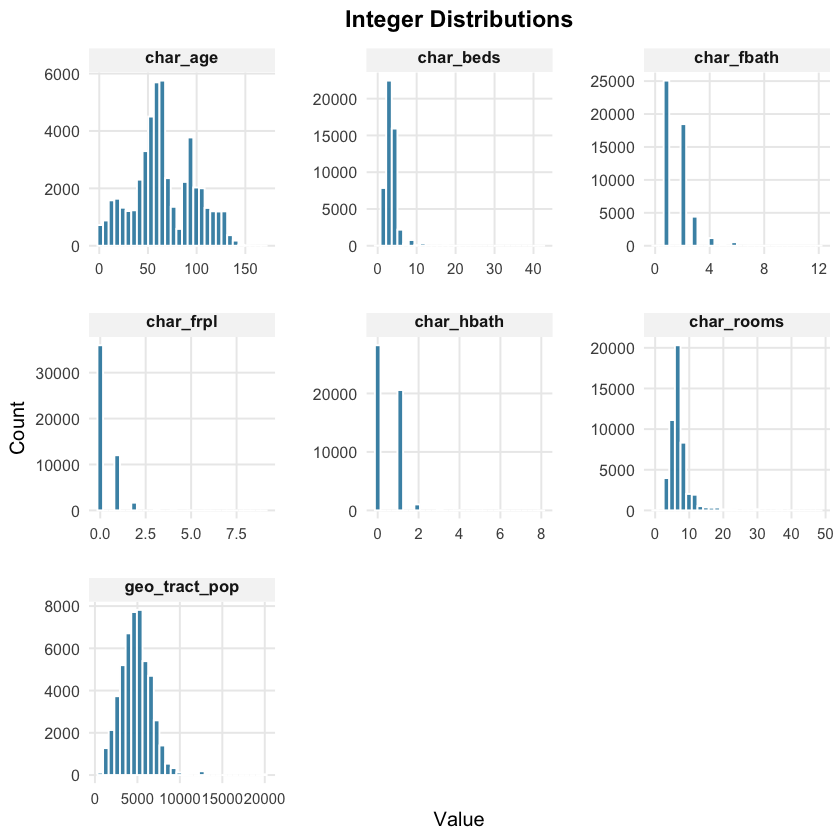

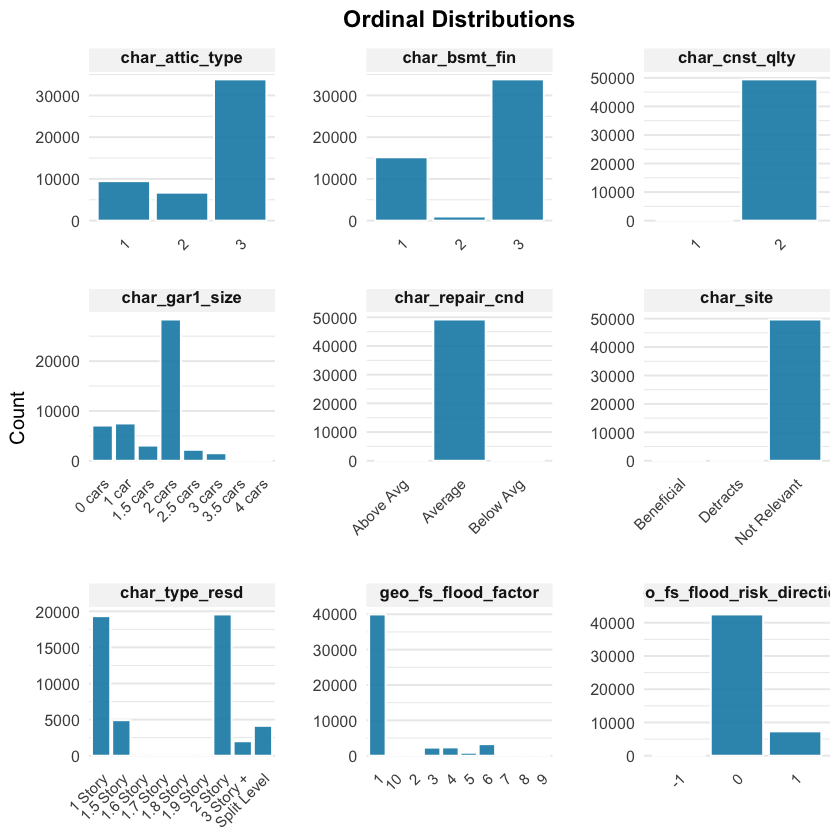

In [67]:
cat("=== Integer & Ordinal Distributions (Faceted Histograms: historic_data only) ===\n")

# Hardcoded mapping for ordinal variable value -> English label
ordinal_label_map <- list(
  char_air = c(`1` = "Central A/C", `2` = "No Central A/C"),
  char_apts = c(`1` = "Two", `2` = "Three", `3` = "Four", `4` = "Five", `5` = "Six", `6` = "None"),
  char_attic_fnsh = c(`1` = "Living Area", `2` = "Partial", `3` = "None"),
  char_ext_wall = c(`1` = "Frame", `2` = "Masonry", `3` = "Frame + Masonry", `4` = "Stucco"),
  char_gar1_area = c(`1` = "Yes", `2` = "No"),
  char_gar1_att = c(`1` = "Yes", `2` = "No"),
  char_gar1_cnst = c(`1` = "Frame", `2` = "Masonry"),
  char_gar1_size = c(`1` = "1 car", `2` = "1.5 cars", `3` = "2 cars", `4` = "2.5 cars", `5` = "3 cars", `6` = "3.5 cars", `7` = "0 cars", `8` = "4 cars"),
  char_heat = c(`1` = "Warm Air Furnace", `2` = "Hot Water Steam", `3` = "Electric Heater", `4` = "None"),
  char_oheat = c(`1` = "Floor Furnace", `2` = "Unit Heater", `3` = "Stove", `4` = "Solar", `5` = "None"),
  char_porch = c(`1` = "Frame Encl.", `2` = "Masonry Encl.", `3` = "None"),
  char_renovation = c(`1` = "Yes", `2` = "No"),
  char_repair_cnd = c(`1` = "Above Avg", `2` = "Average", `3` = "Below Avg"),
  char_roof_cnst = c(`1` = "Shingle+Asphalt", `2` = "Tar+Gravel", `3` = "Slate", `4` = "Shake", `5` = "Tile", `6` = "Other"),
  char_site = c(`1` = "Beneficial", `2` = "Not Relevant", `3` = "Detracts"),
  char_tp_dsgn = c(`1` = "Yes", `2` = "No"),
  char_tp_plan = c(`1` = "Architect", `2` = "Stock Plan"),
  char_type_resd = c(
    `1` = "1 Story", `2` = "2 Story", `3` = "3 Story +", `4` = "Split Level",
    `5` = "1.5 Story", `6` = "1.6 Story", `7` = "1.7 Story", `8` = "1.8 Story", `9` = "1.9 Story"
  )
)

plot_batched_histograms <- function(vars, label, batch_size = 9) {
  # Filter to vars that actually exist
  vars <- vars[vars %in% names(historic_data)]
  if (length(vars) == 0) return(invisible(NULL))
  
  # Split variables into chunks to prevent overcrowding
  var_chunks <- split(vars, ceiling(seq_along(vars) / batch_size))
  
  for (i in seq_along(var_chunks)) {
    chunk_vars <- var_chunks[[i]]
    
    # Process data for this chunk
    data_list <- lapply(chunk_vars, function(v) {
      vec <- historic_data[[v]]
      
      # Handle Ordinal Mapping
      if (label == "Ordinal") {
        # Check if we have a map
        if (v %in% names(ordinal_label_map)) {
          # Map values
          mapped_vals <- ordinal_label_map[[v]][as.character(vec)]
          # If map fails (NA), fall back to original value
          final_vals <- ifelse(is.na(mapped_vals), as.character(vec), mapped_vals)
          data.frame(Variable = v, Value = final_vals, stringsAsFactors = FALSE)
        } else {
          # No map, use raw
          data.frame(Variable = v, Value = as.character(vec), stringsAsFactors = FALSE)
        }
      } else {
        # Integer processing
        data.frame(Variable = v, Value = as.numeric(vec), stringsAsFactors = FALSE)
      }
    })
    
    plot_data <- dplyr::bind_rows(data_list) %>% 
      dplyr::filter(!is.na(Value))
    
    # Create Title
    suffix <- if (length(var_chunks) > 1) sprintf(" (Batch %d of %d)", i, length(var_chunks)) else ""
    plot_title <- paste0(label, " Distributions", suffix)
    
    # PLOTTING LOGIC
    if (label == "Integer") {
      p <- ggplot(plot_data, aes(x = Value)) +
        geom_histogram(fill = "#2E86AB", color = "white", bins = 30, alpha = 0.9) +
        facet_wrap(~Variable, scales = "free", ncol = 3) +
        theme_minimal(base_size = 12) +
        theme(
          plot.title = element_text(face = "bold", size = 14, hjust = 0.5, margin = ggplot2::margin(b=10)),
          strip.text = element_text(face = "bold", size = 10,  margin = ggplot2::margin(b=5)),
          strip.background = element_rect(fill = "grey96", color = NA),
          axis.text.x = element_text(size = 9),
          panel.grid.minor = element_blank(),
          panel.spacing = unit(1.5, "lines") # Space out facets
        ) +
        labs(title = plot_title, x = "Value", y = "Count")
      
    } else {
      # Ordinal Plotting
      # Wrap long text labels in the data
      plot_data$Value <- stringr::str_wrap(plot_data$Value, width = 15)
      
      p <- ggplot(plot_data, aes(x = Value)) +
        geom_bar(fill = "#118AB2", color = "white", alpha = 0.9) +
        facet_wrap(~Variable, scales = "free", ncol = 3) +
        theme_minimal(base_size = 12) +
        theme(
          plot.title = element_text(face = "bold", size = 14, hjust = 0.5, margin = ggplot2::margin(b=10)),
          strip.text = element_text(face = "bold", size = 10, margin = ggplot2::margin(b=5)),
          strip.background = element_rect(fill = "grey96", color = NA),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 9), # Angle text to fit
          panel.grid.major.x = element_blank(),
          panel.spacing = unit(1.5, "lines")
        ) +
        labs(title = plot_title, x = NULL, y = "Count")
    }
    
    print(p)
  }
}

# Execute
plot_batched_histograms(integer_vars, "Integer")
plot_batched_histograms(ordinal_vars, "Ordinal")

#### Boxplots: Continuous Variable Spread

=== Continuous Variable Spread (Boxplots) ===

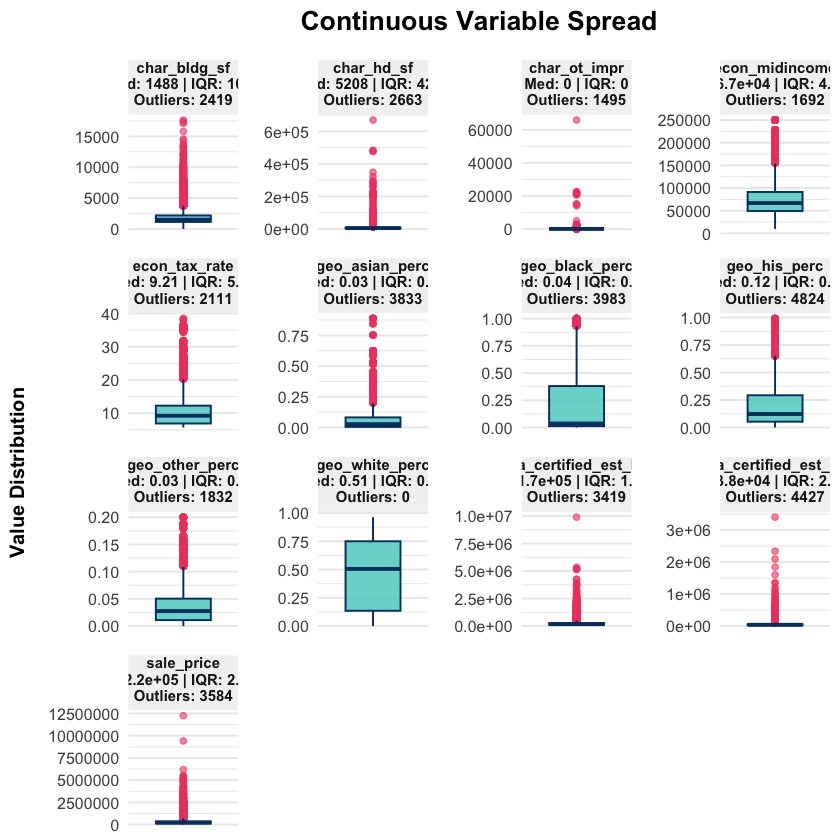

In [68]:
cat("=== Continuous Variable Spread (Boxplots) ===")

# Use all continuous variables that exist in historic_data
continuous_vars_historic <- continuous_vars[continuous_vars %in% names(historic_data)]

if (length(continuous_vars_historic) > 0) {
  
  # Use ALL continuous vars in historic_data
  vars_to_plot <- continuous_vars_historic
  
  # 1. Calculate summary stats for each variable to build facet labels
  summary_stats <- purrr::map_dfr(vars_to_plot, function(var) {
    vals <- historic_data[[var]][!is.na(historic_data[[var]])]
    Q1   <- quantile(vals, 0.25, na.rm = TRUE)
    Q3   <- quantile(vals, 0.75, na.rm = TRUE)
    IQR_val <- Q3 - Q1
    lower_bound <- Q1 - 1.5 * IQR_val
    upper_bound <- Q3 + 1.5 * IQR_val
    outlier_count <- sum(vals < lower_bound | vals > upper_bound, na.rm = TRUE)
    med_val <- median(vals, na.rm = TRUE)
    
    fmt <- function(x) {
      if (is.na(x)) return(NA_character_)
      if (abs(x) > 10000) {
        formatC(x, format = "e", digits = 1)
      } else {
        round(x, 2)
      }
    }
    
    label_text <- paste0(
      var, "\n",
      "Med: ", fmt(med_val), " | IQR: ", fmt(IQR_val), "\n",
      "Outliers: ", outlier_count
    )
    
    tibble::tibble(
      Variable = var,
      Label    = label_text
    )
  })
  
  # 2. Build plotting dataframe and join facet labels
  plot_df <- purrr::map_dfr(vars_to_plot, function(var) {
    tibble::tibble(
      Variable = var,
      Value    = historic_data[[var]]
    )
  }) %>%
    dplyr::left_join(summary_stats, by = "Variable")
  
  # Determine columns in facet grid (up to 4 wide)
  facet_cols <- min(4, length(vars_to_plot))
  
  # 3. Generate plot with one boxplot per facet (all continuous vars)
  p <- ggplot(plot_df, aes(y = Value, x = "")) +
    geom_boxplot(
      fill          = "#4ECDC4",
      color         = "#023E73",
      alpha         = 0.8,
      outlier.colour = "#EF476F",
      outlier.size  = 1.5,
      outlier.alpha = 0.6,
      width         = 0.6
    ) +
    facet_wrap(~ Label, scales = "free", ncol = facet_cols) +
    theme_minimal(base_size = 12) +
    theme(
      plot.title = element_text(
        size   = 16,
        face   = "bold",
        hjust  = 0.5,
        margin = ggplot2::margin(b = 15)
      ),
      strip.text = element_text(
        face   = "bold",
        size   = 9,
        margin = ggplot2::margin(b = 5)
      ),
      strip.background   = element_rect(fill = "grey95", color = NA),
      axis.title.x       = element_blank(),
      axis.text.x        = element_blank(),
      axis.ticks.x       = element_blank(),
      axis.title.y       = element_text(face = "bold", margin = ggplot2::margin(r = 10)),
      panel.grid.major.x = element_blank(),
      panel.spacing      = unit(1, "lines")
    ) +
    labs(
      title = "Continuous Variable Spread",
      y     = "Value Distribution"
    )
  
  print(p)
}

#### Pie Charts: Nominal Variable Distributions

=== Nominal Variable Distributions (Pie Charts) ===


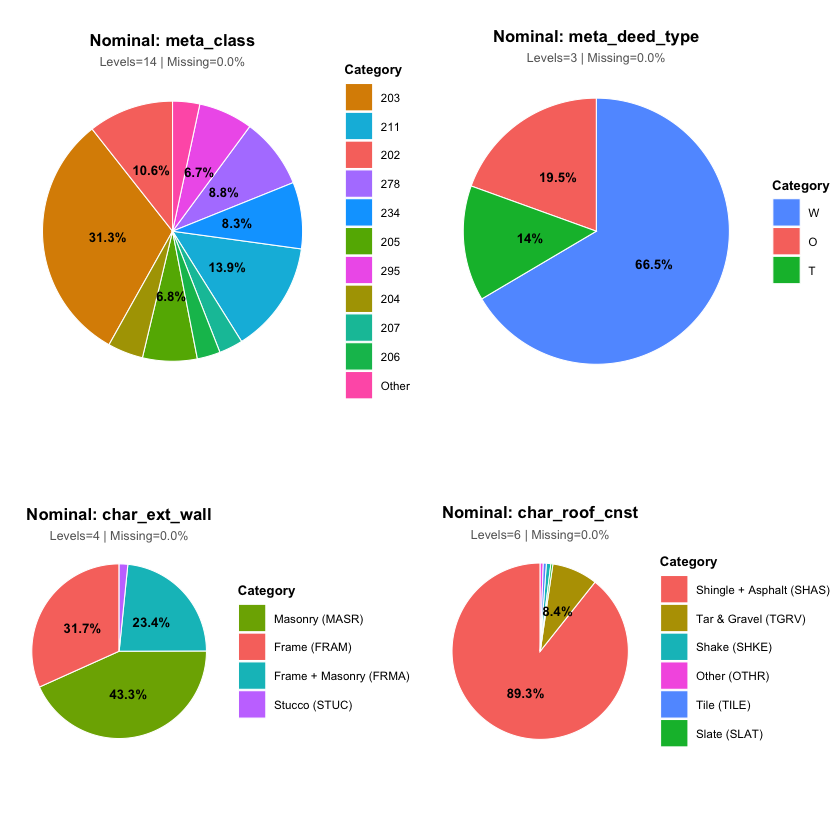

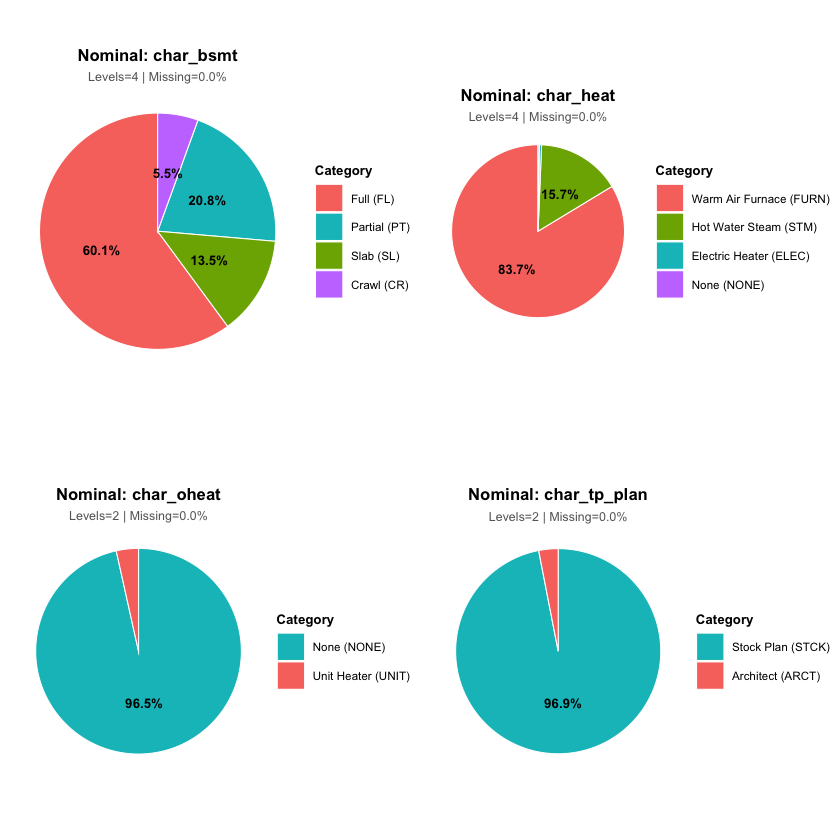

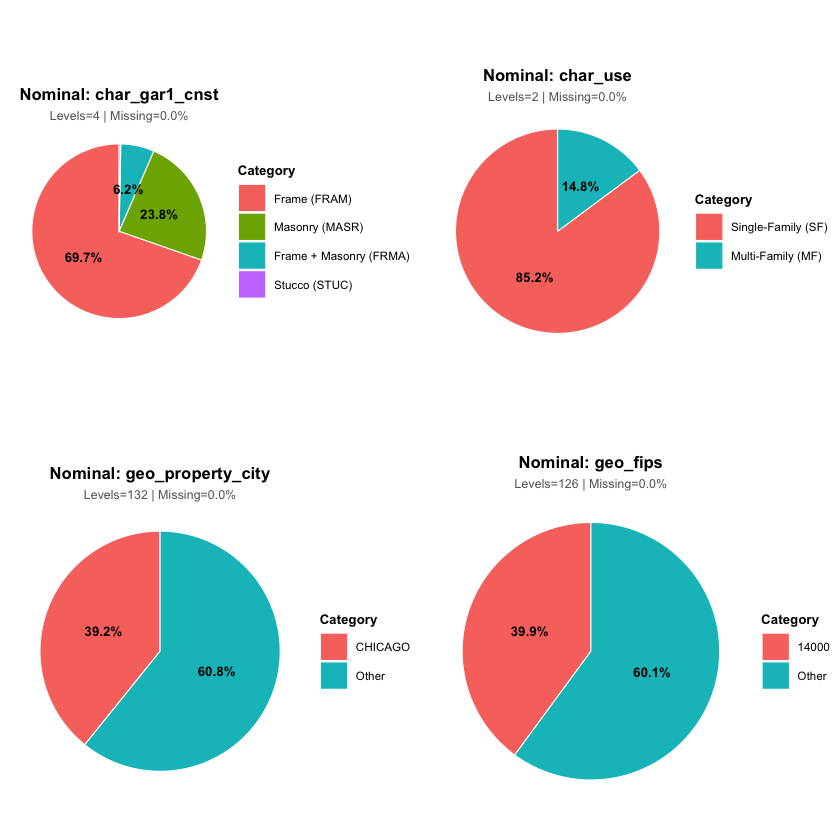

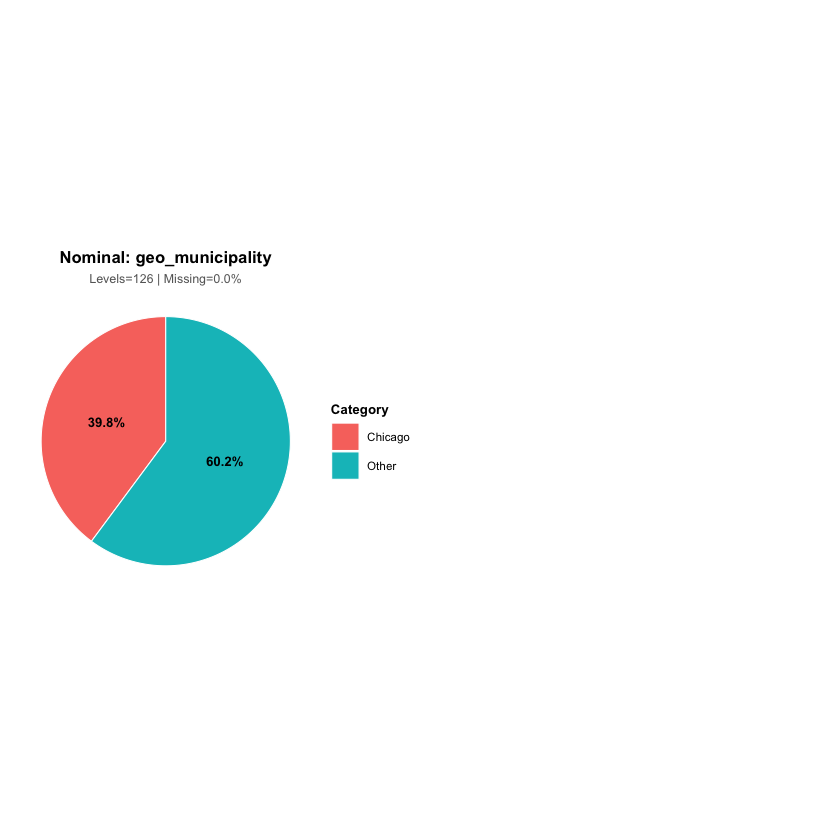

In [69]:
cat("=== Nominal Variable Distributions (Pie Charts) ===\n")

# 1) Explicit nominal variable list (from summary)
nominal_vars_historic <- c(
  "meta_class", "meta_town_code", "meta_nbhd", "meta_deed_type",
  "char_ext_wall", "char_roof_cnst", "char_bsmt", "char_heat",
  "char_oheat", "char_tp_plan", "char_gar1_cnst", "char_use",
  "geo_property_city", "geo_property_zip", "geo_fips", "geo_municipality",
  "geo_school_elem_district", "geo_school_hs_district", "ind_arms_length"
)

nominal_vars_historic <- nominal_vars_historic[nominal_vars_historic %in% names(historic_data)]

# 2) Codebook label maps for coded nominal vars
nominal_codebook_maps <- list(
  char_ext_wall    = c("1" = "Frame (FRAM)", "2" = "Masonry (MASR)", "3" = "Frame + Masonry (FRMA)", "4" = "Stucco (STUC)"),
  char_roof_cnst   = c("1" = "Shingle + Asphalt (SHAS)", "2" = "Tar & Gravel (TGRV)", "3" = "Slate (SLAT)", "4" = "Shake (SHKE)", "5" = "Tile (TILE)", "6" = "Other (OTHR)"),
  char_bsmt        = c("1" = "Full (FL)", "2" = "Slab (SL)", "3" = "Partial (PT)", "4" = "Crawl (CR)"),
  char_heat        = c("1" = "Warm Air Furnace (FURN)", "2" = "Hot Water Steam (STM)", "3" = "Electric Heater (ELEC)", "4" = "None (NONE)"),
  char_oheat       = c("1" = "Floor Furnace (FURN)", "2" = "Unit Heater (UNIT)", "3" = "Stove (STVE)", "4" = "Solar (SOLR)", "5" = "None (NONE)"),
  char_tp_plan     = c("1" = "Architect (ARCT)", "2" = "Stock Plan (STCK)"),
  char_gar1_cnst   = c("1" = "Frame (FRAM)", "2" = "Masonry (MASR)", "3" = "Frame + Masonry (FRMA)", "4" = "Stucco (STUC)"),
  char_use         = c("1" = "Single-Family (SF)", "2" = "Multi-Family (MF)"),
  ind_arms_length  = c("1" = "Arms Length (TRUE)", "2" = "Non-Arms Length (FALSE)")
)

# thresholds to keep charts readable
high_card_threshold <- 30
major_share_cut     <- 0.15
max_levels_full     <- 10

nominal_pies <- list()

if (length(nominal_vars_historic) > 0) {
  for (var in nominal_vars_historic) {
    x <- historic_data[[var]]
    freq_table <- table(x, useNA = "no")
    if (length(freq_table) <= 1) next

    df <- as.data.frame(freq_table)
    colnames(df) <- c("Code", "Count")
    df$Code <- as.character(df$Code)

    # map coded categories to labels where we have a map
    if (var %in% names(nominal_codebook_maps)) {
      map_vec <- nominal_codebook_maps[[var]]
      codes   <- names(map_vec)
      labels  <- unname(map_vec)
      df <- df %>%
        dplyr::filter(Code %in% codes) %>%
        mutate(
          Code  = factor(Code, levels = codes),
          Label = labels[match(Code, codes)]
        )
    } else {
      df <- df %>%
        mutate(
          Code  = factor(Code),
          Label = as.character(Code)
        )
    }

    if (nrow(df) == 0L) next

    df <- df %>%
      arrange(desc(Count)) %>%
      mutate(Prop = Count / sum(Count))

    k_levels <- nrow(df)

    # high-cardinality: only sizeable levels + "Other"
    if (k_levels > high_card_threshold) {
      major_df <- df %>% dplyr::filter(Prop >= major_share_cut)
      if (nrow(major_df) == 0L) next
      other_count <- sum(df$Count[!(df$Code %in% major_df$Code)])
      df_plot <- major_df %>% dplyr::select(Code, Label, Count)
      if (other_count > 0) {
        df_plot <- dplyr::bind_rows(
          df_plot,
          tibble::tibble(Code = factor("Other"),
                         Label = "Other",
                         Count = other_count)
        )
      }
    } else if (k_levels > max_levels_full) {
      top_df <- df[1:max_levels_full, ]
      other_count <- sum(df$Count[(max_levels_full + 1):k_levels])
      df_plot <- top_df %>% dplyr::select(Code, Label, Count)
      if (other_count > 0) {
        df_plot <- dplyr::bind_rows(
          df_plot,
          tibble::tibble(Code = factor("Other"),
                         Label = "Other",
                         Count = other_count)
        )
      }
    } else {
      df_plot <- df %>% dplyr::select(Code, Label, Count)
    }

    df_plot <- df_plot %>%
      mutate(
        Percentage = round(Count / sum(Count) * 100, 1),
        SliceLabel = ifelse(Percentage >= 5, paste0(Percentage, "%"), "")
      )

    legend_breaks <- as.character(df_plot$Code)
    legend_labels <- df_plot$Label

    p_pie <- ggplot(df_plot, aes(x = "", y = Count, fill = Code)) +
      geom_bar(stat = "identity", width = 1, color = "white", linewidth = 0.3) +
      coord_polar("y", start = 0) +
      geom_text(
        aes(label = SliceLabel),
        position = position_stack(vjust = 0.5),
        size = 2.8,
        fontface = "bold",
        color = "black"
      ) +
      theme_void(base_size = 9) +
      theme(
        plot.title    = element_text(size = 10, face = "bold", hjust = 0.5),
        plot.subtitle = element_text(size = 7.5, hjust = 0.5, color = "gray40"),
        legend.position = "right",
        legend.title = element_text(size = 8, face = "bold"),
        legend.text  = element_text(size = 7),
        plot.margin  = ggplot2::margin(6, 6, 6, 6)
      ) +
      labs(
        title    = paste("Nominal:", var),
        subtitle = sprintf("Levels=%d | Missing=%.1f%%",
                           length(freq_table),
                           mean(is.na(x)) * 100),
        fill = "Category"
      ) +
      scale_fill_discrete(
        breaks = legend_breaks,
        labels = legend_labels
      )

    nominal_pies[[var]] <- p_pie
  }
}

if (length(nominal_pies) > 0) {
  # chunk into small batches so each panel gets more space:
  batch_size <- 4      # 2 columns x 2 rows per "page"
  n_plots    <- length(nominal_pies)
  idx_start  <- seq(1, n_plots, by = batch_size)

  for (s in idx_start) {
    e <- min(s + batch_size - 1, n_plots)
    gridExtra::grid.arrange(
      grobs = nominal_pies[s:e],
      ncol  = 2
    )
  }
}

#### Bar Charts: Logical / Boolean Variable Ratios

=== Boolean Variable Distributions (Bar Charts) ===


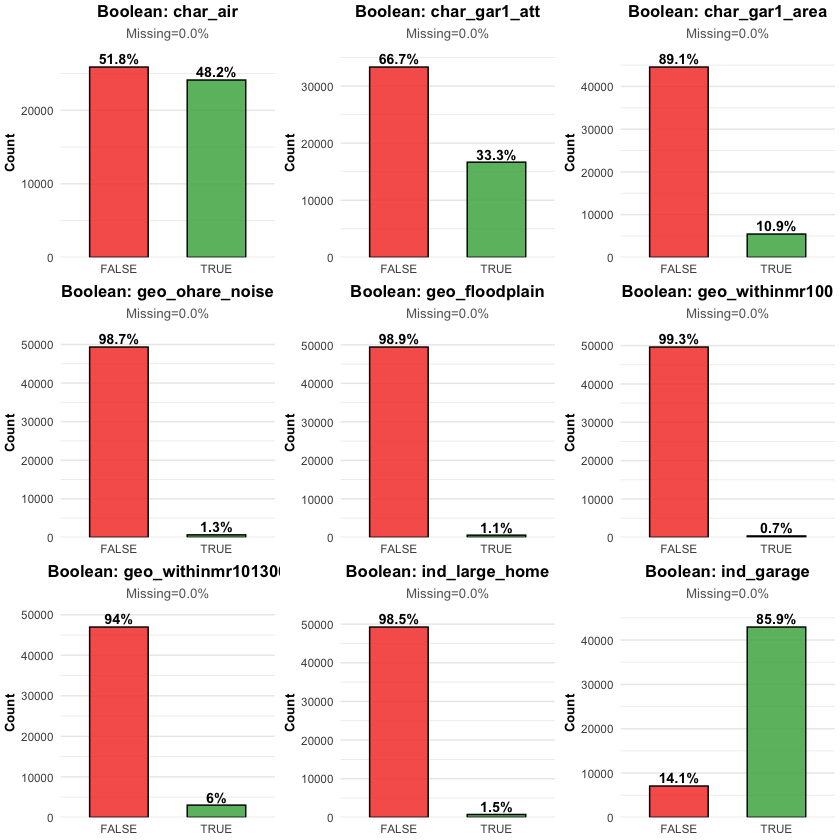

In [70]:
cat("=== Boolean Variable Distributions (Bar Charts) ===\n")

plots <- list()

if (length(boolean_vars) > 0) {
  for (var in boolean_vars) {
    if (var %in% names(historic_data)) {
      vals <- as.logical(historic_data[[var]])
      
      freq_data <- data.frame(
        Value = c("TRUE", "FALSE"),
        Count = c(sum(vals, na.rm = TRUE), sum(!vals, na.rm = TRUE))
      ) %>%
        mutate(
          Percentage = round(Count / pmax(sum(Count), 1) * 100, 1),
          Label      = paste0(Percentage, "%")
        )
      
      p_bar <- ggplot(freq_data, aes(x = Value, y = Count, fill = Value)) +
        geom_bar(stat = "identity", color = "black", alpha = 0.85, width = 0.6) +
        geom_text(aes(label = Label), vjust = -0.3, size = 3, fontface = "bold") +
        theme_minimal(base_size = 9) +
        theme(
          plot.title        = element_text(size = 10, face = "bold", hjust = 0.5),
          plot.subtitle     = element_text(size = 8, hjust = 0.5, color = "gray40"),
          axis.title.x      = element_text(size = 8, face = "bold"),
          axis.title.y      = element_text(size = 8, face = "bold"),
          axis.text         = element_text(size = 7),
          legend.position   = "none",
          panel.grid.major.x = element_blank(),
          plot.margin       = ggplot2::margin(3, 3, 3, 3)
        ) +
        labs(
          title    = paste("Boolean:", var),
          subtitle = sprintf("Missing=%.1f%%", mean(is.na(vals)) * 100),
          x        = NULL,
          y        = "Count"
        ) +
        scale_fill_manual(values = c("TRUE" = "#4CAF50", "FALSE" = "#F44336")) +
        scale_y_continuous(expand = expansion(mult = c(0, 0.10)))
      
      plots[[var]] <- p_bar
    }
  }
}

if (length(plots) > 0) {
  # Arrange plots in up to a 3x3 grid
  n_plots <- length(plots)
  gridExtra::grid.arrange(grobs = plots, ncol = 3)
}

#### Correlation Analysis (Pearson, Spearman, Cramer's V)

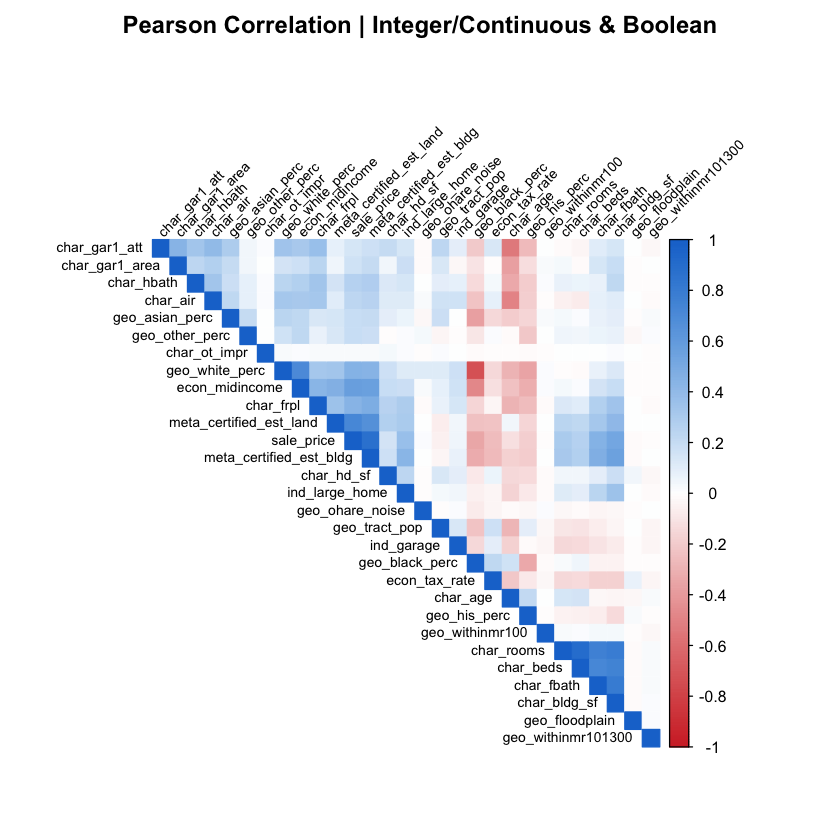

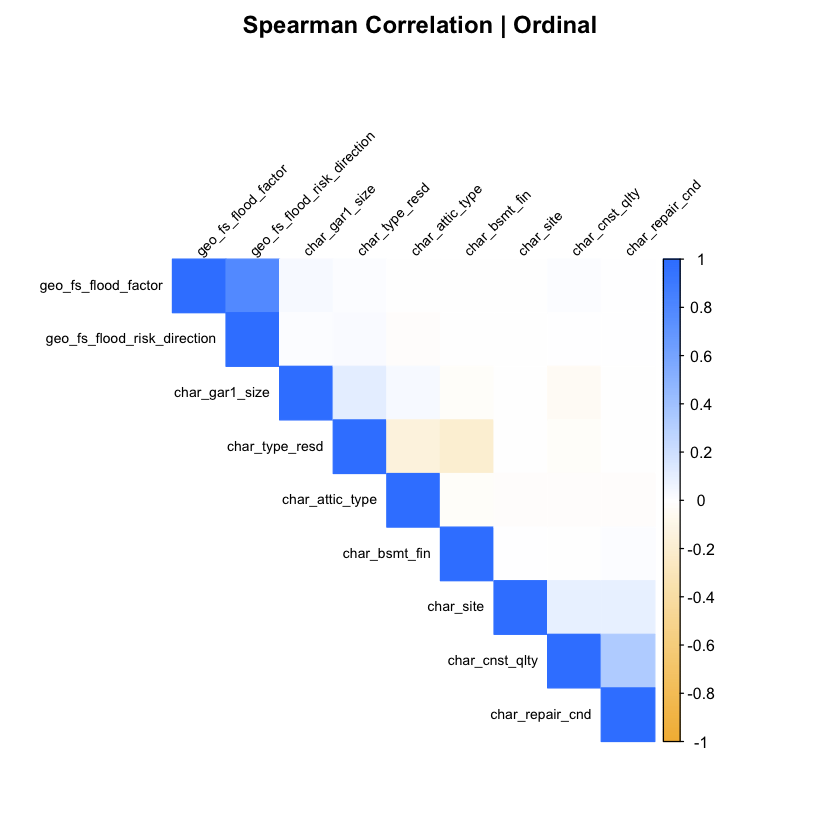

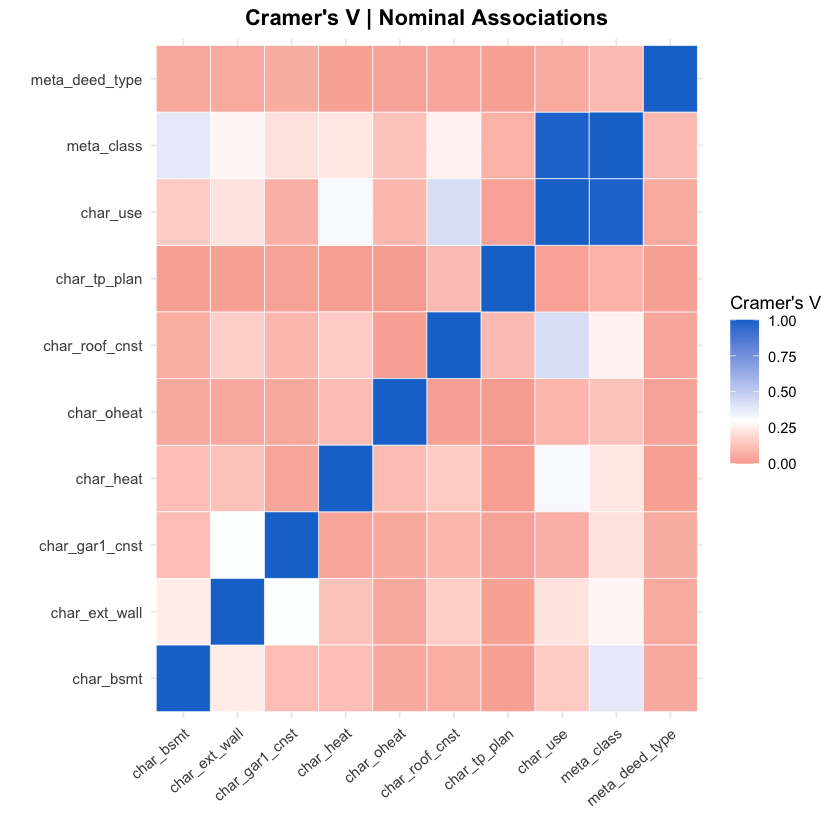

In [71]:
# Variable type vectors
numeric_for_corr <- names(var_type_map_historic)[var_type_map_historic %in% c("Integer", "Continuous")]
boolean_for_corr <- names(var_type_map_historic)[var_type_map_historic == "Boolean"]
ordinal_for_corr <- names(var_type_map_historic)[var_type_map_historic == "Ordinal"]
nominal_for_corr <- names(var_type_map_historic)[var_type_map_historic == "Nominal"]

numeric_for_corr <- intersect(numeric_for_corr, names(historic_data))
boolean_for_corr <- intersect(boolean_for_corr, names(historic_data))
ordinal_for_corr <- intersect(ordinal_for_corr, names(historic_data))
nominal_for_corr <- intersect(nominal_for_corr, names(historic_data))

# 1. Pearson for numeric + booleans (0/1)
if (length(numeric_for_corr) + length(boolean_for_corr) >= 2) {
  cor_data <- historic_data %>%
    dplyr::select(any_of(c(numeric_for_corr, boolean_for_corr)))

  # convert booleans to numeric 0/1
  for (b in boolean_for_corr) {
    if (b %in% names(cor_data)) {
      col <- cor_data[[b]]
      if (is.logical(col)) {
        cor_data[[b]] <- as.numeric(col)
      } else if (is.factor(col) && nlevels(col) == 2) {
        cor_data[[b]] <- as.numeric(col) - 1L
      }
    }
  }

  # keep only numeric, non-constant columns
  cor_data <- cor_data %>%
    dplyr::select(where(is.numeric)) %>%
    dplyr::select(where(~ stats::var(.x, na.rm = TRUE) > 0))

  if (ncol(cor_data) >= 2) {
    cor_matrix <- stats::cor(cor_data, use = "pairwise.complete.obs", method = "pearson")

    corrplot(
      cor_matrix,
      method = "color",
      type   = "upper",
      order  = "hclust",
      tl.col = "black",
      tl.srt = 45,
      tl.cex = 0.7,
      cl.cex = 0.8,
      col    = colorRampPalette(c("#D32F2F", "#FFFFFF", "#1976D2"))(200),
      title  = "Pearson Correlation | Integer/Continuous & Boolean",
      mar    = c(0, 0, 2, 0)
    )
  } else {
    cat("  [Pearson] Fewer than 2 usable numeric/boolean columns after filtering.\n")
  }
}

# 2. Spearman for ordinal (rank-based)
if (length(ordinal_for_corr) >= 2) {
  ord_data <- historic_data %>%
    dplyr::select(all_of(ordinal_for_corr))

  # convert to numeric ranks, drop constant columns
  ord_data_num <- ord_data %>%
    mutate(across(everything(), ~ as.numeric(as.factor(.x)))) %>%
    dplyr::select(where(~ stats::var(.x, na.rm = TRUE) > 0))

  if (ncol(ord_data_num) >= 2) {
    ord_matrix <- stats::cor(ord_data_num, use = "pairwise.complete.obs", method = "spearman")

    corrplot(
      ord_matrix,
      method = "color",
      type   = "upper",
      order  = "hclust",
      tl.col = "black",
      tl.srt = 45,
      tl.cex = 0.7,
      cl.cex = 0.8,
      col    = colorRampPalette(c("#F4B942", "#FFFFFF", "#3A86FF"))(200),
      title  = "Spearman Correlation | Ordinal",
      mar    = c(0, 0, 2, 0)
    )
  } else {
    cat("  [Spearman] Fewer than 2 usable ordinal columns after filtering.\n")
  }
}

# 3. Cramer's V for nominal (categorical association)
cramers_v_safe <- function(x, y) {
  x <- as.factor(x)
  y <- as.factor(y)
  ok <- !is.na(x) & !is.na(y)
  x <- x[ok]
  y <- y[ok]

  if (length(x) == 0L || length(y) == 0L) return(NA_real_)

  # lengths must match for table(x, y)
  if (length(x) != length(y)) return(NA_real_)

  tbl <- table(x, y)
  if (nrow(tbl) < 2 || ncol(tbl) < 2) return(NA_real_)

  chi <- suppressWarnings(chisq.test(tbl))
  n   <- sum(tbl)
  if (n == 0) return(NA_real_)

  min_dim <- min(nrow(tbl), ncol(tbl)) - 1
  if (min_dim <= 0) return(NA_real_)

  as.numeric(sqrt(chi$statistic / (n * min_dim)))
}

# keep only nominal vars with reasonable cardinality
nominal_for_corr_small <- nominal_for_corr[sapply(nominal_for_corr, function(v) {
  nlevels <- length(unique(historic_data[[v]]))
  nlevels > 1 && nlevels <= 15
})]

if (length(nominal_for_corr_small) > 10) {
  nominal_for_corr_small <- nominal_for_corr_small[1:10]
}

if (length(nominal_for_corr_small) >= 2) {
  # compute pairwise Cramer's V using combn → no manual matrix indexing
  pairs <- utils::combn(nominal_for_corr_small, 2, simplify = FALSE)

  cv_pairs <- lapply(pairs, function(p) {
    v1 <- p[1]
    v2 <- p[2]
    val <- cramers_v_safe(historic_data[[v1]], historic_data[[v2]])
    data.frame(Var1 = v1, Var2 = v2, Value = val, stringsAsFactors = FALSE)
  })

  cv_df <- do.call(rbind, cv_pairs)
  cv_df <- cv_df[!is.na(cv_df$Value), , drop = FALSE]

  if (nrow(cv_df) > 0) {
    # symmetrize for heatmap: add Var2↔Var1 and diagonal=1
    vars_all <- sort(unique(c(cv_df$Var1, cv_df$Var2)))

    cv_sym <- cv_df
    cv_sym <- rbind(
      cv_sym,
      data.frame(Var1 = cv_df$Var2, Var2 = cv_df$Var1, Value = cv_df$Value, stringsAsFactors = FALSE),
      data.frame(Var1 = vars_all,   Var2 = vars_all,   Value = 1,          stringsAsFactors = FALSE)
    )
    
    p_cv <- ggplot(cv_sym, aes(x = Var1, y = Var2, fill = Value)) +
      geom_tile(color = "white") +
      scale_fill_gradient2(
        low  = "#D32F2F",
        mid  = "#FFFFFF",
        high = "#1976D2",
        midpoint = 0.3,
        limits   = c(0, 1),
        oob      = scales::squish
      ) +
      theme_minimal(base_size = 11) +
      theme(
        axis.text.x = element_text(angle = 40, hjust = 1, size = 9),
        axis.text.y = element_text(size = 9),
        plot.title  = element_text(face = "bold", hjust = 0.5)
      ) +
      labs(
        title = "Cramer's V | Nominal Associations",
        x = "",
        y = "",
        fill = "Cramer's V"
      )

    print(p_cv)
  } else {
    cat("  [Cramer's V] No valid nominal pairs after filtering.\n")
  }
} else {
  cat("  [Cramer's V] Fewer than 2 nominal variables with acceptable cardinality.\n")
}

---
### **OLS, Decision Tree, Elastic Net, Random Forest, & XGB Modeling**

#### Model Feature Types

In [72]:
## Turn into a tidy data.frame
var_types <- data.frame(
  variable = names(historic_data),
  class    = sapply(historic_data, function(x) paste(class(x), collapse = ", ")),
  row.names = NULL
)

print(var_types)

## If you use dplyr
dplyr::glimpse(historic_data)

                      variable           class
1                   sale_price         numeric
2                   meta_class          factor
3               meta_town_code          factor
4                    meta_nbhd          factor
5      meta_certified_est_bldg         numeric
6      meta_certified_est_land         numeric
7               meta_deed_type          factor
8                   char_hd_sf         numeric
9                     char_age         numeric
10               char_ext_wall          factor
11              char_roof_cnst          factor
12                  char_rooms         numeric
13                   char_beds         numeric
14                   char_bsmt          factor
15               char_bsmt_fin ordered, factor
16                   char_heat          factor
17                  char_oheat          factor
18                    char_air          factor
19                   char_frpl         numeric
20             char_attic_type ordered, factor
21           

#### 70/30 Train:Validation Set Split

In [73]:
set.seed(2047)  # for reproducibility

n <- nrow(historic_data)
train_idx <- sample(seq_len(n), size = floor(0.7 * n))

historic_data_train <- historic_data[train_idx, ]
historic_data_val   <- historic_data[-train_idx, ]


#### OLS Regression Model

In [74]:
## 1. Combine train + val so factor levels are consistent

data_all <- rbind(historic_data_train, historic_data_val)

## 2. Keep only allowed column types (numeric + factors)

is_allowed_type <- sapply(data_all, function(x) {
  is.numeric(x) || is.integer(x) || is.factor(x)
})
data_all <- data_all[ , is_allowed_type, drop = FALSE]

## 3. Drop / filter very high-cardinality factors
# Threshold for maximum allowed levels in a factor for OLS
max_factor_levels <- 40  # tweak as needed

factor_cols <- names(data_all)[sapply(data_all, is.factor)]

factor_levels <- sapply(factor_cols, function(nm) nlevels(data_all[[nm]]))
high_card_factors <- names(factor_levels[factor_levels > max_factor_levels])

if (length(high_card_factors) > 0) {
  cat("Dropping high-cardinality factors from OLS (levels >", max_factor_levels, "):\n")
  print(data.frame(
    variable = high_card_factors,
    n_levels = factor_levels[high_card_factors],
    row.names = NULL
  ))
  
  data_all <- data_all[ , !(names(data_all) %in% high_card_factors), drop = FALSE]
}

## 4. Coerce integer -> numeric

for (nm in names(data_all)) {
  x <- data_all[[nm]]
  if (is.integer(x)) {
    data_all[[nm]] <- as.numeric(x)
  }
}

## Ensure target is numeric

stopifnot("sale_price" %in% names(data_all))
data_all$sale_price <- as.numeric(data_all$sale_price)

## 5. Re-split into train / validation

n_train <- nrow(historic_data_train)

train_data <- data_all[1:n_train, , drop = FALSE]
val_data   <- data_all[(n_train + 1):nrow(data_all), , drop = FALSE]

## 6. Drop incomplete rows (if any remain)

train_data <- train_data[complete.cases(train_data), ]
val_data   <- val_data[complete.cases(val_data), ]

cat("Training rows after filtering:", nrow(train_data), "\n")
cat("Validation rows after filtering:", nrow(val_data), "\n")
cat("Predictors in OLS model:", ncol(train_data) - 1, "\n")

## 7. Fit OLS model on training set

ols_formula <- as.formula("sale_price ~ .")

ols_model <- lm(ols_formula, data = train_data)

summary(ols_model)  # inspect coefficients, R^2, etc.

## 8. Evaluate on validation set

val_pred <- predict(ols_model, newdata = val_data)

y_true <- val_data$sale_price
y_hat  <- val_pred

rmse <- sqrt(mean((y_true - y_hat)^2))
mae  <- mean(abs(y_true - y_hat))

sst <- sum((y_true - mean(y_true))^2)
sse <- sum((y_true - y_hat)^2)
r2_val <- 1 - sse / sst

cat("Validation RMSE:", rmse, "\n")
cat("Validation MAE :", mae,  "\n")
cat("Validation R^2 :", r2_val, "\n")

model_results <- if (exists("model_results")) model_results else data.frame(
  model = character(),
  RMSE = numeric(),
  MAE = numeric(),
  R2 = numeric(),
  stringsAsFactors = FALSE
)

model_results <- rbind(model_results, data.frame(
  model = "OLS Model",
  RMSE = rmse,
  MAE = mae,
  R2 = r2_val,
  stringsAsFactors = FALSE
))

Dropping high-cardinality factors from OLS (levels > 40 ):
                  variable n_levels
1                meta_nbhd      845
2        geo_property_city      132
3         geo_property_zip      169
4                 geo_fips      126
5         geo_municipality      126
6 geo_school_elem_district      475
7   geo_school_hs_district       79
Training rows after filtering: 35000 
Validation rows after filtering: 15000 
Predictors in OLS model: 49 



Call:
lm(formula = ols_formula, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2272393   -47570    -2637    38944  8262223 

Coefficients: (1 not defined because of singularities)
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    1.562e+05  6.370e+04   2.452 0.014194 *  
meta_class203                 -5.562e+03  2.733e+03  -2.035 0.041830 *  
meta_class204                 -1.368e+04  4.769e+03  -2.869 0.004126 ** 
meta_class205                  1.247e+04  6.202e+03   2.011 0.044311 *  
meta_class206                  4.909e+04  7.419e+03   6.616 3.73e-11 ***
meta_class207                  7.756e+02  7.273e+03   0.107 0.915072    
meta_class208                  7.048e+04  1.037e+04   6.798 1.08e-11 ***
meta_class209                  4.609e+04  1.463e+04   3.150 0.001636 ** 
meta_class210                  3.479e+03  8.478e+03   0.410 0.681565    
meta_class211                 -1.639e+05  1.673e+04  -9.79

Validation RMSE: 119281.9 
Validation MAE : 67524.49 
Validation R^2 : 0.8602332 


#### Decision Tree Model

In [75]:
set.seed(2047)  # same seed structure as before

# 1) Train / validation split ---------------------------------------------

n <- nrow(historic_data)
train_idx <- sample(seq_len(n), size = floor(0.7 * n))

historic_data_train <- historic_data[train_idx, ]
historic_data_val   <- historic_data[-train_idx, ]

# 2) Combine so encodings are consistent ----------------------------------

data_all <- rbind(historic_data_train, historic_data_val)

prep_for_tree <- function(df) {
  dat <- df
  
  # keep only usable types
  is_allowed <- sapply(dat, function(x)
    is.numeric(x) || is.integer(x) || is.factor(x) || is.logical(x))
  dat <- dat[ , is_allowed, drop = FALSE]
  
  # ensure target exists
  stopifnot("sale_price" %in% names(dat))
  
  # logical -> factor
  log_cols <- names(dat)[sapply(dat, is.logical)]
  for (nm in log_cols) {
    dat[[nm]] <- factor(dat[[nm]])
  }
  
  # integer -> numeric
  int_cols <- names(dat)[sapply(dat, is.integer)]
  for (nm in int_cols) {
    dat[[nm]] <- as.numeric(dat[[nm]])
  }
  
  # ensure response is numeric
  dat$sale_price <- as.numeric(dat$sale_price)
  
  # rpart: factors with > 32 levels cause issues; convert to numeric IDs
  fact_cols <- setdiff(names(dat)[sapply(dat, is.factor)], "sale_price")
  high_card <- fact_cols[sapply(fact_cols, function(v) nlevels(dat[[v]]) > 32)]
  if (length(high_card) > 0) {
    cat("Converting high-cardinality factors to numeric IDs for tree:\n")
    print(data.frame(
      variable = high_card,
      n_levels = sapply(high_card, function(v) nlevels(dat[[v]])),
      row.names = NULL
    ))
    for (nm in high_card) {
      dat[[nm]] <- as.numeric(dat[[nm]])
    }
  }
  
  dat
}

data_all_tree <- prep_for_tree(data_all)

# 3) Re-split into train / validation -------------------------------------

n_train   <- nrow(historic_data_train)
train_data <- data_all_tree[1:n_train, , drop = FALSE]
val_data   <- data_all_tree[(n_train + 1):nrow(data_all_tree), , drop = FALSE]

# Drop incomplete rows (tree can handle some NA, but for clean metrics we drop)
train_data <- train_data[complete.cases(train_data), ]
val_data   <- val_data[complete.cases(val_data), ]

cat("Decision Tree | training rows:", nrow(train_data), "\n")
cat("Decision Tree | validation rows:", nrow(val_data), "\n")
cat("Decision Tree | predictors:", ncol(train_data) - 1, "\n")

# 4) Fit decision tree ----------------------------------------------------

tree_formula <- as.formula("sale_price ~ .")

dt_model <- rpart(
  formula = tree_formula,
  data    = train_data,
  method  = "anova",
  control = rpart.control(
    cp       = 0.001,  # complexity penalty; tune if desired
    minsplit = 20,
    maxdepth = 20
  )
)

cat("\nComplexity parameter table:\n")
printcp(dt_model)

# Prune to cp with minimum cross-validated error
best_cp <- dt_model$cptable[which.min(dt_model$cptable[, "xerror"]), "CP"]
cat("\nUsing cp =", best_cp, "for pruned tree.\n")
dt_pruned <- prune(dt_model, cp = best_cp)

# 5) Evaluate on validation set -------------------------------------------

val_pred <- predict(dt_pruned, newdata = val_data)

y_true <- val_data$sale_price
y_hat  <- val_pred

rmse <- sqrt(mean((y_true - y_hat)^2))
mae  <- mean(abs(y_true - y_hat))

sst <- sum((y_true - mean(y_true))^2)
sse <- sum((y_true - y_hat)^2)
r2_val <- 1 - sse / sst

cat("\nDecision Tree - Validation RMSE:", rmse, "\n")
cat("Decision Tree - Validation MAE :", mae,  "\n")
cat("Decision Tree - Validation R^2 :", r2_val, "\n")

model_results <- rbind(model_results, data.frame(
  model = "Decision Tree Model",
  RMSE = rmse,
  MAE = mae,
  R2 = r2_val,
  stringsAsFactors = FALSE
))

Converting high-cardinality factors to numeric IDs for tree:
                  variable n_levels
1           meta_town_code       38
2                meta_nbhd      845
3        geo_property_city      132
4         geo_property_zip      169
5                 geo_fips      126
6         geo_municipality      126
7 geo_school_elem_district      475
8   geo_school_hs_district       79
Decision Tree | training rows: 35000 
Decision Tree | validation rows: 15000 
Decision Tree | predictors: 56 

Complexity parameter table:

Regression tree:
rpart(formula = tree_formula, data = train_data, method = "anova", 
    control = rpart.control(cp = 0.001, minsplit = 20, maxdepth = 20))

Variables actually used in tree construction:
 [1] char_age                 char_bldg_sf             char_rooms              
 [4] econ_midincome           geo_school_elem_district meta_certified_est_bldg 
 [7] meta_certified_est_land  meta_class               meta_deed_type          
[10] meta_nbhd               

R

#### Ridge / Lasso (Elastic Net) Model

In [76]:
# Use the *same* train_data / val_data you used for OLS after all preprocessing
x_train <- model.matrix(sale_price ~ ., data = train_data)[, -1]
y_train <- train_data$sale_price

x_val   <- model.matrix(sale_price ~ ., data = val_data)[, -1]
y_val   <- val_data$sale_price

set.seed(2047)
cv_ridge <- cv.glmnet(
  x = x_train,
  y = y_train,
  alpha = 0.5,          # 0 = Ridge, 1 = Lasso, in between = Elastic Net
  nfolds = 5
)

best_lambda <- cv_ridge$lambda.min

y_hat_ridge <- as.numeric(predict(cv_ridge, s = best_lambda, newx = x_val))

rmse_ridge <- sqrt(mean((y_val - y_hat_ridge)^2))
mae_ridge  <- mean(abs(y_val - y_hat_ridge))

sst <- sum((y_val - mean(y_val))^2)
sse <- sum((y_val - y_hat_ridge)^2)
r2_ridge <- 1 - sse / sst

cat("Ridge RMSE:", rmse_ridge, "\n")
cat("Ridge MAE :", mae_ridge,  "\n")
cat("Ridge R^2 :", r2_ridge,   "\n")

model_results <- rbind(model_results, data.frame(
  model = "Ridge / Lasso (Elastic Net) Model",
  RMSE = rmse_ridge,
  MAE = mae_ridge,
  R2 = r2_ridge,
  stringsAsFactors = FALSE
))


Ridge RMSE: 119869.6 
Ridge MAE : 68215.1 
Ridge R^2 : 0.8588526 


#### Random Forest Model

In [77]:
set.seed(2047)

# 1. PRE-PROCESSING: Drop High-Cardinality features
# RF cannot handle >53 levels, and high cardinality slows it down regardless.
drop_cols <- c("meta_nbhd", "geo_property_city", "geo_property_zip", 
               "geo_fips", "geo_municipality", "geo_school_elem_district", 
               "geo_school_hs_district")

# created filtered datasets for RF
train_rf <- train_data[, !(names(train_data) %in% drop_cols)]
val_rf   <- val_data[, !(names(val_data) %in% drop_cols)]

cat("High cardinality columns dropped. Remaining predictors:", ncol(train_rf)-1, "\n")

set.seed(2047)
rf_model <- randomForest(
  sale_price ~ .,
  data     = train_rf,
  ntree    = 300,                    # Full tree count for final model
  mtry     = 24,
  nodesize = 1,
  sampsize = 7000,
  importance = TRUE
)

# 5. Final Evaluation
rf_pred <- predict(rf_model, newdata = val_rf)

y_true <- val_rf$sale_price
y_hat  <- rf_pred

rmse_rf <- sqrt(mean((y_true - y_hat)^2))
mae_rf  <- mean(abs(y_true - y_hat))
sst     <- sum((y_true - mean(y_true))^2)
sse     <- sum((y_true - y_hat)^2)
r2_rf   <- 1 - sse / sst

cat("--------------------------------------\n")
cat("RF RMSE:", rmse_rf, "\n")
cat("RF MAE:", mae_rf,  "\n")
cat("RF R^2:", r2_rf,   "\n")

# Store results
model_results <- rbind(model_results, data.frame(
  model = "Random Forest (Standard Package + Tuned)",
  RMSE = rmse_rf,
  MAE = mae_rf,
  R2 = r2_rf,
  stringsAsFactors = FALSE
))

High cardinality columns dropped. Remaining predictors: 49 
--------------------------------------
RF RMSE: 133297 
RF MAE: 61534.9 
RF R^2: 0.8254598 


#### Hyperparameter Titration & Convergence RF Model

In [78]:
# 1. PRE-PROCESSING: Drop High-Cardinality features for Speed
# Ranger handles factors well, but 800+ levels will still choke the optimization loop.
drop_cols <- c("meta_nbhd", "geo_property_city", "geo_property_zip", 
               "geo_fips", "geo_municipality", "geo_school_elem_district", 
               "geo_school_hs_district")

# Create filtered datasets specifically for this model
train_rf_opt <- train_data[, !(names(train_data) %in% drop_cols)]
val_rf_opt   <- val_data[, !(names(val_data) %in% drop_cols)]

# 2. Define the scoring function (Optimized for Speed)
rf_evaluate <- function(mtry, min_node_size, sample_fraction) {
  
  # Ranger requires integer values
  mtry <- floor(mtry)
  min_node_size <- floor(min_node_size)
  
  set.seed(2047)
  
  # Train with only 50 trees inside the loop
  model <- ranger(
    formula         = sale_price ~ ., 
    data            = train_rf_opt, 
    num.trees       = 50,              # Reduced from 500
    mtry            = mtry,
    min.node.size   = min_node_size,
    sample.fraction = sample_fraction,
    respect.unordered.factors = "order", 
    verbose         = FALSE,
    num.threads     = parallel::detectCores() - 1 # Use all cores
  )
  
  # Predict on validation set
  preds <- predict(model, data = val_rf_opt)$predictions
  
  # Calculate RMSE (Negative for Maximization)
  rmse_val <- sqrt(mean((val_rf_opt$sale_price - preds)^2))
  
  return(list(Score = -rmse_val, Pred = 0))
}

# 3. Define the Search Space
p <- ncol(train_rf_opt) - 1

search_bounds <- list(
  mtry            = c(2L, p),             
  min_node_size   = c(1L, 20L),           
  sample_fraction = c(0.5, 0.9) # Cap at 0.9 to ensure some randomness/speed
)

cat("Starting Bayesian Optimization (Fast Mode)...\n")

# 4. Run Bayesian Optimization
set.seed(2047)
opt_results <- BayesianOptimization(
  FUN = rf_evaluate,
  bounds = search_bounds,
  init_points = 5,      # 5 Random starts
  n_iter = 10,          # 10 Intelligent steps (reduced from 15)
  acq = "ucb",          
  kappa = 2.576,
  eps = 0.0,
  verbose = TRUE
)

# 5. Extract Best Parameters
best_params <- opt_results$Best_Par
cat("\nBest Parameters Found:\n")
print(best_params)

# 6. Train Final Model with Best Parameters (Full Power)
# Now that we know the best settings, we run the full 500 trees.
cat("Training Final Model with Best Parameters...\n")

set.seed(2047)
final_rf_model <- ranger(
  formula         = sale_price ~ ., 
  data            = train_rf_opt, 
  num.trees       = 300,  # Back to full size
  mtry            = floor(best_params["mtry"]),
  min.node.size   = floor(best_params["min_node_size"]),
  sample.fraction = best_params["sample_fraction"],
  respect.unordered.factors = "order",
  importance      = "impurity"
)

# 7. Final Evaluation
rf_pred <- predict(final_rf_model, data = val_rf_opt)$predictions

y_true <- val_rf_opt$sale_price
y_hat  <- rf_pred

rmse_rf_opt <- sqrt(mean((y_true - y_hat)^2))
mae_rf_opt  <- mean(abs(y_true - y_hat))
sst         <- sum((y_true - mean(y_true))^2)
sse         <- sum((y_true - y_hat)^2)
r2_rf_opt   <- 1 - sse / sst

cat("--------------------------------------\n")
cat("RF (Tuned) RMSE:", rmse_rf_opt, "\n")
cat("RF (Tuned) MAE:", mae_rf_opt, "\n")
cat("RF (Tuned) R^2:", r2_rf_opt, "\n")

model_results <- rbind(model_results, data.frame(
  model = "Hyperparameter Titration & Convergence RF Model",
  RMSE = rmse_rf_opt,
  MAE = mae_rf_opt,
  R2 = r2_rf_opt,
  stringsAsFactors = FALSE
))

Starting Bayesian Optimization (Fast Mode)...
elapsed = 1.791	Round = 1	mtry = 29.13187	min_node_size = 4.0000	sample_fraction = 0.6522388	Value = -128411.9489 
elapsed = 1.447	Round = 2	mtry = 21.58866	min_node_size = 10.0000	sample_fraction = 0.8888561	Value = -129493.6218 
elapsed = 0.746	Round = 3	mtry = 10.95144	min_node_size = 15.0000	sample_fraction = 0.8078946	Value = -135778.2904 
elapsed = 1.235	Round = 4	mtry = 22.87236	min_node_size = 9.0000	sample_fraction = 0.6879963	Value = -131060.7102 
elapsed = 3.20	Round = 5	mtry = 43.5941	min_node_size = 1.0000	sample_fraction = 0.7541665	Value = -128604.4893 
elapsed = 0.427	Round = 6	mtry = 2.0000	min_node_size = 5.0000	sample_fraction = 0.9000	Value = -153189.1866 
elapsed = 2.13	Round = 7	mtry = 41.55579	min_node_size = 20.0000	sample_fraction = 0.9000	Value = -129565.2118 
elapsed = 2.42	Round = 8	mtry = 49.0000	min_node_size = 20.0000	sample_fraction = 0.9000	Value = -131244.1999 
elapsed = 2.028	Round = 9	mtry = 36.76466	min_

#### XGBoost Model

In [79]:
set.seed(2047)

# 1. PRE-PROCESSING
# We drop the same high-cardinality columns to ensure speed and apples-to-apples comparison
drop_cols <- c("meta_nbhd", "geo_property_city", "geo_property_zip", 
               "geo_fips", "geo_municipality", "geo_school_elem_district", 
               "geo_school_hs_district")

# Filter datasets
train_xgb_df <- train_data[, !(names(train_data) %in% drop_cols)]
val_xgb_df   <- val_data[, !(names(val_data) %in% drop_cols)]

cat("Creating Sparse Matrices (One-Hot Encoding)...\n")

# Create Model Matrices (One-Hot Encoding)
# Using sparse.model.matrix is much faster and memory efficient for XGBoost
x_train_sparse <- sparse.model.matrix(sale_price ~ ., data = train_xgb_df)[, -1]
y_train        <- train_xgb_df$sale_price

x_val_sparse   <- sparse.model.matrix(sale_price ~ ., data = val_xgb_df)[, -1]
y_val          <- val_xgb_df$sale_price

# Convert to xgb.DMatrix (XGBoost's native format)
dtrain <- xgb.DMatrix(data = x_train_sparse, label = y_train)
dval   <- xgb.DMatrix(data = x_val_sparse,   label = y_val)

# 2. DEFINE HYPERPARAMETERS
# These are robust defaults that typically beat Ridge/RF without needing hours of tuning
xgb_params <- list(
  objective        = "reg:squarederror",
  eta              = 0.05,    # Learning rate (lower = more precise, slower)
  max_depth        = 6,       # Standard depth (RF usually effectively deeper)
  subsample        = 0.7,     # Row sampling (prevents overfitting)
  colsample_bytree = 0.7,     # Column sampling (similar to mtry in RF)
  tree_method      = "hist"   # CRITICAL: Histogram binning makes this lightning fast
)

cat("Training XGBoost Model with Early Stopping...\n")

# 3. TRAIN MODEL
# We set nrounds high (2000), but 'early_stopping_rounds' will stop it 
# automatically if it doesn't improve for 50 rounds.
start_time <- Sys.time()

xgb_model <- xgb.train(
  params                  = xgb_params,
  data                    = dtrain,
  nrounds                 = 2000,
  watchlist               = list(train = dtrain, val = dval),
  early_stopping_rounds   = 50,
  print_every_n           = 100,
  verbose                 = 1
)

end_time <- Sys.time()
cat("Training Time:", end_time - start_time, "\n")

# 4. PREDICT & EVALUATE
# The predict function automatically uses the 'best_iteration' found
y_hat_xgb <- predict(xgb_model, x_val_sparse)

rmse_xgb <- sqrt(mean((y_val - y_hat_xgb)^2))
mae_xgb  <- mean(abs(y_val - y_hat_xgb))
sst      <- sum((y_val - mean(y_val))^2)
sse      <- sum((y_val - y_hat_xgb)^2)
r2_xgb   <- 1 - sse / sst

cat("\n--------------------------------------\n")
cat("XGBoost RMSE:", rmse_xgb, "\n")
cat("XGBoost MAE:", mae_xgb,  "\n")
cat("XGBoost R^2:", r2_xgb,   "\n")

# Store results
model_results <- rbind(model_results, data.frame(
  model = "XGBoost (Early Stopping)",
  RMSE = rmse_xgb,
  MAE = mae_xgb,
  R2 = r2_xgb,
  stringsAsFactors = FALSE
))

Creating Sparse Matrices (One-Hot Encoding)...


Training XGBoost Model with Early Stopping...
[1]	train-rmse:414949.335437	val-rmse:416672.890321 
Multiple eval metrics are present. Will use val_rmse for early stopping.
Will train until val_rmse hasn't improved in 50 rounds.

[101]	train-rmse:91923.408099	val-rmse:134527.281258 
[201]	train-rmse:80680.099437	val-rmse:131973.514801 
[301]	train-rmse:73947.856694	val-rmse:131097.351326 
[401]	train-rmse:68508.667380	val-rmse:130522.614762 
[501]	train-rmse:64180.989183	val-rmse:130041.987934 
[601]	train-rmse:60767.729402	val-rmse:129810.453059 
[701]	train-rmse:57685.047833	val-rmse:129508.671982 
[801]	train-rmse:54895.174911	val-rmse:129451.344418 
[901]	train-rmse:52501.564200	val-rmse:129415.422414 
Stopping. Best iteration:
[884]	train-rmse:52843.480763	val-rmse:129395.093622

Training Time: 2.700478 

--------------------------------------
XGBoost RMSE: 129395.1 
XGBoost MAE: 58770.42 
XGBoost R^2: 0.8355286 


#### Model Evaluation

In [80]:
model_results

model,RMSE,MAE,R2
<chr>,<dbl>,<dbl>,<dbl>
OLS Model,119281.9,67524.49,0.8602332
Decision Tree Model,153975.1,77147.09,0.7671074
Ridge / Lasso (Elastic Net) Model,119869.6,68215.10,0.8588526
Random Forest (Standard Package + Tuned),133297.0,61534.90,0.8254598
Hyperparameter Titration & Convergence RF Model,127518.7,61041.24,0.8402642
XGBoost (Early Stopping),129395.1,58770.42,0.8355286
OLS Model,132151.4,69714.20,0.8280074
Decision Tree Model,182503.1,79273.81,0.6719751
Ridge / Lasso (Elastic Net) Model,132102.8,69585.10,0.8281338


---
### **Outlier Handling & Normalization**

In [ ]:
set.seed(2047)

# ------------------------------------------------------------------------------
# STEP 1: Split Data
# ------------------------------------------------------------------------------
sample_index <- createDataPartition(historic_data$sale_price, p = 0.8, list = FALSE)
train_data   <- historic_data[sample_index, ]
val_data     <- historic_data[-sample_index, ]

# ------------------------------------------------------------------------------
# STEP 2: Intelligent Outlier Handling (Train ONLY)
# ------------------------------------------------------------------------------
# We use the verified list of numeric variables.
numeric_check_cols <- c(
  "char_age", "char_rooms", "char_beds", "char_frpl", "char_fbath", "char_hbath", "geo_tract_pop",
  "sale_price", "meta_certified_est_bldg", "meta_certified_est_land", "char_hd_sf", "char_ot_impr", 
  "char_bldg_sf", "geo_white_perc", "geo_black_perc", "geo_asian_perc", "geo_his_perc", "geo_other_perc", 
  "econ_tax_rate", "econ_midincome"
)

# Function: Log-Transform skewed vars BEFORE checking Z-scores
# This prevents dropping valid luxury homes.
check_outlier_logic <- function(x) {
  if (all(is.na(x))) return(rep(TRUE, length(x)))
  
  # Check skewness. If > 0.75, use Log space for Z-score calculation
  use_log <- is.numeric(x) && abs(skewness(x, na.rm = TRUE)) > 0.75
  
  if (use_log) {
    # log1p safely handles zeros
    x_trans <- suppressWarnings(log1p(x)) 
  } else {
    x_trans <- x
  }
  
  # Calculate Z-scores
  z_scores <- abs(scale(x_trans, center = TRUE, scale = TRUE)[, 1])
  
  # Keep if Z <= 3.5 (Slightly relaxed to keep more upper-tail data)
  return(z_scores <= 3.5 | is.na(z_scores))
}

n_before <- nrow(train_data)
train_data <- train_data %>%
  filter(if_all(all_of(numeric_check_cols), check_outlier_logic))

cat("Rows dropped:", n_before - nrow(train_data), "\n")
cat("Rows remaining:", nrow(train_data), "\n")

# ------------------------------------------------------------------------------
# STEP 3: Scaling / Normalization
# ------------------------------------------------------------------------------
# We scale predictors, but we EXCLUDE sale_price from the scaler.
# We will handle sale_price via Log Transformation in the model formula.

vars_to_scale <- setdiff(numeric_check_cols, "sale_price")

# Learn parameters from Train
preproc_values <- preProcess(train_data[, vars_to_scale], method = c("center", "scale"))

# Apply to Train and Val
train_data_scaled <- predict(preproc_values, train_data)
val_data_scaled   <- predict(preproc_values, val_data)

Outlier Removal Summary:
Rows dropped: 5431 
Rows remaining: 34571 


#### OLS Regression Model v2

In [ ]:
# ------------------------------------------------------------------------------
# STEP 5: Log-Target OLS Model
# ------------------------------------------------------------------------------
# CRITICAL FIX: We predict log(sale_price). 
# This aligns the linear model with the log-normal distribution of real estate prices.

# Create log target column to make formula cleaner
train_data_scaled$log_sale_price <- log(train_data_scaled$sale_price)

# Formula: Predict Log Price using all columns EXCEPT original sale_price
ols_formula <- as.formula("log_sale_price ~ . - sale_price")

ols_model <- lm(ols_formula, data = train_data_scaled)

# ------------------------------------------------------------------------------
# STEP 6: Evaluation
# ------------------------------------------------------------------------------
# 1. Predict Log Price
log_pred <- predict(ols_model, newdata = val_data_scaled)

# 2. Exponentiate to get Real Dollars
val_pred <- exp(log_pred)

y_true <- val_data_scaled$sale_price
y_hat  <- val_pred

rmse <- sqrt(mean((y_true - y_hat)^2))
mae  <- mean(abs(y_true - y_hat))
sst  <- sum((y_true - mean(y_true))^2)
sse  <- sum((y_true - y_hat)^2)
r2_val <- 1 - sse / sst

cat("\n--- Optimized OLS Results ---\n")
cat("Validation RMSE:", rmse, "\n")
cat("Validation MAE:", mae,  "\n")
cat("Validation R^2:", r2_val, "\n")

# Update Results Table
model_results <- if (exists("model_results")) model_results else data.frame(
  model = character(), RMSE = numeric(), MAE = numeric(), R2 = numeric(), stringsAsFactors = FALSE
)
model_results <- rbind(model_results, data.frame(
  model = "OLS (Log-Target & Scaled)", RMSE = rmse, MAE = mae, R2 = r2_val
))

Dropping high-cardinality factors from OLS (levels > 40 ):
                  variable n_levels
1                meta_nbhd      845
2        geo_property_city      132
3         geo_property_zip      169
4                 geo_fips      126
5         geo_municipality      126
6 geo_school_elem_district      475
7   geo_school_hs_district       79
Training rows after filtering: 34571 
Validation rows after filtering: 9998 
Predictors in OLS model: 49 



Call:
lm(formula = ols_formula, data = train_data_scaled)

Residuals:
    Min      1Q  Median      3Q     Max 
-909103  -44027   -2777   35756 1932757 

Coefficients: (2 not defined because of singularities)
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    354790.59   18242.09  19.449  < 2e-16 ***
meta_class203                   -4045.76    1998.17  -2.025 0.042902 *  
meta_class204                   -8768.52    3701.49  -2.369 0.017846 *  
meta_class205                   14221.70    4578.43   3.106 0.001896 ** 
meta_class206                   57335.36    5694.04  10.069  < 2e-16 ***
meta_class207                   -1141.70    5394.75  -0.212 0.832396    
meta_class208                   43415.20    8662.25   5.012 5.41e-07 ***
meta_class209                  116526.87   17316.21   6.729 1.73e-11 ***
meta_class210                    1386.22    6293.27   0.220 0.825662    
meta_class211                 -144294.78   13889.97 -10.388  

Warning message in predict.lm(ols_model, newdata = val_data_scaled):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


Validation RMSE: 621695.5 
Validation MAE: 90101.82 
Validation R^2: -2.806465 


#### Decision Tree Model v2

In [ ]:
# Use already prepared train_data_scaled and val_data_scaled from the OLS step

# 1. Prepare Data
# Ensure we are using the Log Target (created in the previous OLS step).
# If it doesn't exist for some reason, recreate it.
if(!"log_sale_price" %in% names(train_data_scaled)) {
  train_data_scaled$log_sale_price <- log(train_data_scaled$sale_price)
}

# Remove raw 'sale_price' from predictors to prevent leakage (we predict log_price)
# We also ensure complete cases.
train_data_dt <- train_data_scaled[complete.cases(train_data_scaled), ]
val_data_dt   <- val_data_scaled[complete.cases(val_data_scaled), ]

cat("Decision Tree | training rows:", nrow(train_data_dt), "\n")
cat("Decision Tree | predictors:", ncol(train_data_dt) - 2, "(excluding sale_price/log_sale_price)\n")

# 2. Fit Decision Tree on LOG Price
# We lower 'cp' significantly to grow a deep tree, then rely on Pruning to find the optimal size.
dt_formula <- as.formula("log_sale_price ~ . - sale_price")

set.seed(2047)
dt_model <- rpart(
  formula = dt_formula,
  data    = train_data_dt,
  method  = "anova",
  control = rpart.control(
    cp       = 0.0005,  # Allow tree to grow deep (low penalty initially)
    minsplit = 20,      # Minimum obs to attempt a split
    maxdepth = 30,      # Allow complex interactions
    xval     = 10       # 10-fold CV for robust pruning
  )
)

# 3. Prune the Tree
# Find the CP with the lowest Cross-Validation Error (xerror)
best_cp_index <- which.min(dt_model$cptable[, "xerror"])
best_cp       <- dt_model$cptable[best_cp_index, "CP"]

cat("\nOptimal CP found:", best_cp, "\n")
dt_pruned <- prune(dt_model, cp = best_cp)

# 4. Evaluate on Validation Set
# The model predicts Log Price
log_pred <- predict(dt_pruned, newdata = val_data_dt)

# Exponentiate to get Real Dollars
y_hat  <- exp(log_pred)
y_true <- val_data_dt$sale_price

rmse <- sqrt(mean((y_true - y_hat)^2))
mae  <- mean(abs(y_true - y_hat))

sst <- sum((y_true - mean(y_true))^2)
sse <- sum((y_true - y_hat)^2)
r2_val <- 1 - sse / sst

cat("\nCleaned DT (Log-Target) Validation RMSE:", rmse, "\n")
cat("Cleaned DT (Log-Target) Validation MAE:", mae,  "\n")
cat("Cleaned DT (Log-Target) Validation R^2:", r2_val, "\n")

# 5. Store Results
model_results <- rbind(model_results, data.frame(
  model = "Cleaned Decision Tree (Log-Target)",
  RMSE = rmse,
  MAE = mae,
  R2 = r2_val,
  stringsAsFactors = FALSE
))

Decision Tree | training rows: 34571 
Decision Tree | validation rows: 9998 
Decision Tree | predictors: 49 

Complexity parameter table:

Regression tree:
rpart(formula = tree_formula, data = train_data, method = "anova", 
    control = rpart.control(cp = 0.001, minsplit = 20, maxdepth = 20))

Variables actually used in tree construction:
[1] char_age                econ_midincome          econ_tax_rate          
[4] meta_certified_est_bldg meta_certified_est_land meta_class             
[7] meta_deed_type          meta_town_code         

Root node error: 2.0015e+15/34571 = 5.7897e+10

n= 34571 

          CP nsplit rel error  xerror      xstd
1  0.4836454      0   1.00000 1.00002 0.0199354
2  0.1042664      1   0.51635 0.52012 0.0117303
3  0.0917361      2   0.41209 0.40553 0.0110548
4  0.0195895      3   0.32035 0.32634 0.0090383
5  0.0157804      4   0.30076 0.31744 0.0088627
6  0.0137249      5   0.28498 0.28300 0.0087679
7  0.0117426      6   0.27126 0.27052 0.0086348
8  0.00867

#### Ridge / Lasso (Elastic Net) Model v2

In [ ]:
# 1. Prepare Data
# Ensure we work with complete cases and the Log Target
if(!"log_sale_price" %in% names(train_data_scaled)) {
  train_data_scaled$log_sale_price <- log(train_data_scaled$sale_price)
}

train_data_net <- train_data_scaled[complete.cases(train_data_scaled), ]
val_data_net   <- val_data_scaled[complete.cases(val_data_scaled), ]

# 2. Create Matrices
# IMPORTANT: We predict 'log_sale_price'. 
# We must exclude 'sale_price' (raw) from predictors to prevent leakage.
# We also exclude the intercept column [,-1] generated by model.matrix because glmnet adds its own.

x_train <- model.matrix(log_sale_price ~ . - sale_price, data = train_data_net)[, -1]
y_train <- train_data_net$log_sale_price

x_val   <- model.matrix(log_sale_price ~ . - sale_price, data = val_data_net)[, -1]
y_val   <- val_data_net$sale_price # True raw prices for final evaluation

# 3. Train Elastic Net (Alpha = 0.5)
set.seed(2047)
cv_enet <- cv.glmnet(
  x = x_train,
  y = y_train,
  alpha = 0.5,          # 0.5 = Elastic Net (Mix of Ridge & Lasso)
  nfolds = 5,
  family = "gaussian"   # Standard regression
)

best_lambda <- cv_enet$lambda.min

# 4. Predict
# The model outputs LOG predictions
log_pred <- as.numeric(predict(cv_enet, s = best_lambda, newx = x_val))

# 5. Transform back to Real Dollars
y_hat_enet <- exp(log_pred)

# 6. Evaluate
rmse_enet <- sqrt(mean((y_val - y_hat_enet)^2))
mae_enet  <- mean(abs(y_val - y_hat_enet))

sst <- sum((y_val - mean(y_val))^2)
sse <- sum((y_val - y_hat_enet)^2)
r2_enet <- 1 - sse / sst

cat("Cleaned Elastic Net (Log-Target) RMSE:", rmse_enet, "\n")
cat("Cleaned Elastic Net (Log-Target) MAE:", mae_enet,  "\n")
cat("Cleaned Elastic Net (Log-Target) R^2:", r2_enet,   "\n")

model_results <- rbind(model_results, data.frame(
  model = "Cleaned Elastic Net (Log-Target)",
  RMSE = rmse_enet,
  MAE = mae_enet,
  R2 = r2_enet,
  stringsAsFactors = FALSE
))

Ridge RMSE: 539497 
Ridge MAE: 86841.35 
Ridge R^2: -1.866451 


#### Random Forest v2

In [ ]:
set.seed(2047)

# 1. Prepare Data
# Ensure Log Target exists
if(!"log_sale_price" %in% names(train_data_scaled)) {
  train_data_scaled$log_sale_price <- log(train_data_scaled$sale_price)
}

# 2. Define Columns to Drop
# We DROP the raw 'sale_price' to prevent data leakage (since we predict log_price).
# We also drop the high-cardinality location fields as requested.
drop_cols <- c("meta_nbhd", "geo_property_city", "geo_property_zip", 
               "geo_fips", "geo_municipality", "geo_school_elem_district", 
               "geo_school_hs_district", 
               "sale_price") # <--- Important: Exclude raw target

# Create subset dataframes
# We use complete.cases to ensure RF doesn't fail on NAs
train_rf <- train_data_scaled[complete.cases(train_data_scaled), !(names(train_data_scaled) %in% drop_cols)]
val_rf   <- val_data_scaled[complete.cases(val_data_scaled), !(names(val_data_scaled) %in% drop_cols)]

cat("RF Training rows:", nrow(train_rf), "\n")
cat("RF Predictors:", ncol(train_rf) - 1, "\n")

# 3. Fit Random Forest on LOG Price
# We use min(24, ncol) for mtry just in case the number of columns dropped below 24
set.seed(2047)
rf_model <- randomForest(
  log_sale_price ~ .,
  data     = train_rf,
  ntree    = 300,
  mtry     = min(24, ncol(train_rf) - 1), 
  nodesize = 1,
  sampsize = 7000,
  importance = TRUE
)

# 4. Predict
# The model outputs Log predictions
log_pred <- predict(rf_model, newdata = val_rf)

# 5. Transform Back to Real Dollars
y_hat  <- exp(log_pred)
y_true <- val_data_scaled[complete.cases(val_data_scaled), ]$sale_price

# 6. Evaluate
rmse_rf <- sqrt(mean((y_true - y_hat)^2))
mae_rf  <- mean(abs(y_true - y_hat))
sst     <- sum((y_true - mean(y_true))^2)
sse     <- sum((y_true - y_hat)^2)
r2_rf   <- 1 - sse / sst

cat("--------------------------------------\n")
cat("Cleaned RF (Log-Target) RMSE:", rmse_rf, "\n")
cat("Cleaned RF (Log-Target) MAE:", mae_rf,  "\n")
cat("Cleaned RF (Log-Target) R^2:", r2_rf,   "\n")

# Store results
model_results <- rbind(model_results, data.frame(
  model = "Cleaned Random Forest (Log-Target)",
  RMSE = rmse_rf,
  MAE = mae_rf,
  R2 = r2_rf,
  stringsAsFactors = FALSE
))

High cardinality columns dropped. Remaining predictors: 49 
--------------------------------------
RF RMSE: 146078.9 
RF MAE: 64480.69 
RF R^2: 0.7898441 


#### Hyperparameter Titration & Convergence RF Model v2

In [ ]:
# 1. PRE-PROCESSING: Prepare Log-Target and Drop High-Cardinality/Leakage

# Ensure Log Target exists
if(!"log_sale_price" %in% names(train_data_scaled)) {
  train_data_scaled$log_sale_price <- log(train_data_scaled$sale_price)
}

# Define columns to drop. 
# CRITICAL: We MUST drop "sale_price" (raw) to prevent Data Leakage.
drop_cols <- c("meta_nbhd", "geo_property_city", "geo_property_zip", 
               "geo_fips", "geo_municipality", "geo_school_elem_district", 
               "geo_school_hs_district",
               "sale_price") # <--- Exclude raw target

# Create optimization datasets (Complete cases only)
train_rf_opt <- train_data_scaled[complete.cases(train_data_scaled), !(names(train_data_scaled) %in% drop_cols)]
val_rf_opt   <- val_data_scaled[complete.cases(val_data_scaled), !(names(val_data_scaled) %in% drop_cols)]

# Save the TRUE validation prices for scoring (since we dropped them from the dataframe)
y_val_true <- val_data_scaled[complete.cases(val_data_scaled), ]$sale_price

cat("Optimization Data Prepared.\n")
cat("Training rows:", nrow(train_rf_opt), "\n")
cat("Predictors:", ncol(train_rf_opt) - 1, "\n") # -1 for log_sale_price

# 2. Define the scoring function (Optimized for Speed + Log Logic)
rf_evaluate <- function(mtry, min_node_size, sample_fraction) {
  
  # Ranger requires integer values
  mtry <- floor(mtry)
  min_node_size <- floor(min_node_size)
  
  # TRAIN on LOG Price
  model <- ranger(
    formula         = log_sale_price ~ ., 
    data            = train_rf_opt, 
    num.trees       = 50,  # Low tree count for fast tuning
    mtry            = mtry,
    min.node.size   = min_node_size,
    sample.fraction = sample_fraction,
    respect.unordered.factors = "order", 
    verbose         = FALSE,
    num.threads     = parallel::detectCores() - 1 
  )
  
  # PREDICT Log Price
  log_preds <- predict(model, data = val_rf_opt)$predictions
  
  # CONVERT to Real Dollars
  real_preds <- exp(log_preds)
  
  # CALCULATE RMSE on Real Dollars
  # We use negative RMSE because the optimizer tries to Maximize the function
  rmse_val <- sqrt(mean((y_val_true - real_preds)^2))
  
  return(list(Score = -rmse_val, Pred = 0))
}

# 3. Define the Search Space
p <- ncol(train_rf_opt) - 1 # Total predictors excluding log_sale_price

search_bounds <- list(
  mtry            = c(2L, p),             
  min_node_size   = c(1L, 20L),           
  sample_fraction = c(0.5, 0.9) 
)

cat("Starting Bayesian Optimization (Cleaned + Log-Target Mode)...\n")

# 4. Run Bayesian Optimization
set.seed(2047)
opt_results <- BayesianOptimization(
  FUN = rf_evaluate,
  bounds = search_bounds,
  init_points = 5,      
  n_iter = 10,          
  acq = "ucb",          
  kappa = 2.576,
  eps = 0.0,
  verbose = TRUE
)

# 5. Extract Best Parameters
best_params <- opt_results$Best_Par
cat("\nBest Parameters Found:\n")
print(best_params)

# 6. Train Final Model with Best Parameters (Full Power)
cat("Training Final Model with Best Parameters...\n")

set.seed(2047)
final_rf_model <- ranger(
  formula         = log_sale_price ~ ., 
  data            = train_rf_opt, 
  num.trees       = 500,  # Increased to 500 for stability
  mtry            = floor(best_params["mtry"]),
  min.node.size   = floor(best_params["min_node_size"]),
  sample.fraction = best_params["sample_fraction"],
  respect.unordered.factors = "order",
  importance      = "impurity"
)

# 7. Final Evaluation
log_pred <- predict(final_rf_model, data = val_rf_opt)$predictions

# Back-transform
y_hat  <- exp(log_pred)
y_true <- y_val_true

rmse_rf_opt <- sqrt(mean((y_true - y_hat)^2))
mae_rf_opt  <- mean(abs(y_true - y_hat))
sst         <- sum((y_true - mean(y_true))^2)
sse         <- sum((y_true - y_hat)^2)
r2_rf_opt   <- 1 - sse / sst

cat("--------------------------------------\n")
cat("Cleaned RF (Tuned) RMSE:", rmse_rf_opt, "\n")
cat("Cleaned RF (Tuned) MAE:", mae_rf_opt, "\n")
cat("Cleaned RF (Tuned) R^2:", r2_rf_opt, "\n")

model_results <- rbind(model_results, data.frame(
  model = "Cleaned Hyperparameter Titration & Convergence RF Model",
  RMSE = rmse_rf_opt,
  MAE = mae_rf_opt,
  R2 = r2_rf_opt,
  stringsAsFactors = FALSE
))

Starting Bayesian Optimization (Fast Mode)...
elapsed = 1.883	Round = 1	mtry = 29.13187	min_node_size = 4.0000	sample_fraction = 0.6522388	Value = -141651.1020 
elapsed = 1.482	Round = 2	mtry = 21.58866	min_node_size = 10.0000	sample_fraction = 0.8888561	Value = -142361.6335 
elapsed = 0.74	Round = 3	mtry = 10.95144	min_node_size = 15.0000	sample_fraction = 0.8078946	Value = -145574.6506 
elapsed = 1.306	Round = 4	mtry = 22.87236	min_node_size = 9.0000	sample_fraction = 0.6879963	Value = -140877.5712 
elapsed = 3.851	Round = 5	mtry = 43.5941	min_node_size = 1.0000	sample_fraction = 0.7541665	Value = -140445.5691 
elapsed = 0.292	Round = 6	mtry = 2.0000	min_node_size = 20.0000	sample_fraction = 0.5000	Value = -177466.9631 
elapsed = 0.411	Round = 7	mtry = 2.0000	min_node_size = 1.0000	sample_fraction = 0.9000	Value = -166556.5945 
elapsed = 1.56	Round = 8	mtry = 49.0000	min_node_size = 20.0000	sample_fraction = 0.5000	Value = -143415.9830 
elapsed = 1.721	Round = 9	mtry = 37.99491	min_n

#### XGBoost Model v2

In [ ]:
set.seed(2047)

# 1. PRE-PROCESSING

# Ensure Log Target exists
if(!"log_sale_price" %in% names(train_data_scaled)) {
  train_data_scaled$log_sale_price <- log(train_data_scaled$sale_price)
}

# Define high-cardinality columns to drop
drop_cols <- c("meta_nbhd", "geo_property_city", "geo_property_zip", 
               "geo_fips", "geo_municipality", "geo_school_elem_district", 
               "geo_school_hs_district")

# Subset data (excluding high-cardinality cols, but KEEPING sale_price for now so we can separate it safely)
train_xgb_df <- train_data_scaled[complete.cases(train_data_scaled), !(names(train_data_scaled) %in% drop_cols)]
val_xgb_df   <- val_data_scaled[complete.cases(val_data_scaled), !(names(val_data_scaled) %in% drop_cols)]

cat("Creating Sparse Matrices on Cleaned Data (Log-Target)...\n")

# Create Model Matrices
# CRITICAL: Formula is 'log_sale_price ~ . - sale_price'
# We remove raw 'sale_price' to prevent data leakage.
x_train_sparse <- sparse.model.matrix(log_sale_price ~ . - sale_price, data = train_xgb_df)[, -1]
y_train        <- train_xgb_df$log_sale_price

x_val_sparse   <- sparse.model.matrix(log_sale_price ~ . - sale_price, data = val_xgb_df)[, -1]
y_val_log      <- val_xgb_df$log_sale_price  # Used for Early Stopping (must match model output)
y_val_true     <- val_xgb_df$sale_price      # Used for Final Evaluation (Real Dollars)

# Convert to xgb.DMatrix
dtrain <- xgb.DMatrix(data = x_train_sparse, label = y_train)
dval   <- xgb.DMatrix(data = x_val_sparse,   label = y_val_log)

# 2. DEFINE HYPERPARAMETERS
xgb_params <- list(
  objective        = "reg:squarederror", # Minimizes MSE of Log-Price
  eta              = 0.05,    
  max_depth        = 6,       
  subsample        = 0.7,     
  colsample_bytree = 0.7,     
  tree_method      = "hist"   
)

cat("Training XGBoost Model (Log-Target) with Early Stopping...\n")

# 3. TRAIN MODEL
start_time <- Sys.time()
xgb_model <- xgb.train(
  params                  = xgb_params,
  data                    = dtrain,
  nrounds                 = 2000,
  watchlist               = list(train = dtrain, val = dval),
  early_stopping_rounds   = 50,
  print_every_n           = 100,
  verbose                 = 1
)
end_time <- Sys.time()
cat("Training Time:", end_time - start_time, "\n")

# 4. PREDICT & EVALUATE
# The model predicts Log Price
log_preds <- predict(xgb_model, x_val_sparse)

# Exponentiate to get Real Dollars
y_hat_xgb <- exp(log_preds)

# Compare against True Raw Prices
rmse_xgb <- sqrt(mean((y_val_true - y_hat_xgb)^2))
mae_xgb  <- mean(abs(y_val_true - y_hat_xgb))
sst      <- sum((y_val_true - mean(y_val_true))^2)
sse      <- sum((y_val_true - y_hat_xgb)^2)
r2_xgb   <- 1 - sse / sst

cat("\n--------------------------------------\n")
cat("Cleaned XGBoost (Log-Target) RMSE:", rmse_xgb, "\n")
cat("Cleaned XGBoost (Log-Target) MAE:", mae_xgb,  "\n")
cat("Cleaned XGBoost (Log-Target) R^2:", r2_xgb,   "\n")

# Store results
model_results <- rbind(model_results, data.frame(
  model = "Cleaned XGBoost (Log-Target)",
  RMSE = rmse_xgb,
  MAE = mae_xgb,
  R2 = r2_xgb,
  stringsAsFactors = FALSE
))

Creating Sparse Matrices (One-Hot Encoding) on Scaled Data (High-cardinality columns dropped)...
Training XGBoost Model with Early Stopping...
[1]	train-rmse:349851.196497	val-rmse:420640.980183 
Multiple eval metrics are present. Will use val_rmse for early stopping.
Will train until val_rmse hasn't improved in 50 rounds.

[101]	train-rmse:75989.560527	val-rmse:144103.976133 
[201]	train-rmse:69017.743268	val-rmse:139939.336415 
[301]	train-rmse:64180.560896	val-rmse:138710.589208 
[401]	train-rmse:60088.476458	val-rmse:137558.959503 
[501]	train-rmse:56815.659990	val-rmse:137481.949701 
Stopping. Best iteration:
[457]	train-rmse:58199.218447	val-rmse:137452.750717

Training Time: 1.40303 

--------------------------------------
XGBoost RMSE: 137452.8 
XGBoost MAE: 61277.74 
XGBoost R^2: 0.8139313 


#### Model Evaluation (Post Outlier Handling & Normalization)

In [ ]:
model_results[order(model_results$RMSE), ]

model,RMSE,MAE,R2
<chr>,<dbl>,<dbl>,<dbl>
OLS Model,119281.9,67524.49,0.8602332
Decision Tree Model,153975.1,77147.09,0.7671074
Ridge / Lasso (Elastic Net) Model,119869.6,68215.10,0.8588526
Random Forest (Standard Package + Tuned),133297.0,61534.90,0.8254598
Hyperparameter Titration & Convergence RF Model,127518.7,61041.24,0.8402642
XGBoost (Early Stopping),129395.1,58770.42,0.8355286
OLS Model,132151.4,69714.20,0.8280074
Decision Tree Model,182503.1,79273.81,0.6719751
Ridge / Lasso (Elastic Net) Model,132102.8,69585.10,0.8281338
